# CIS053 Final Project - ML Titanic
Anne-Elise Chung  
Hermanda Mak

## Executive Summary

todo -after everything else

## Background

The purpose of this project is to build a predictive model that can classify the sort of passenger on Titatic that will most likely survive after the shipwreck. Moreover, we aim to discover the most influential features that affect the possibility of survival among the Titanic passengers.

The sinking of the Titanic happened on April 15, 1912, where the resulting death of 1502 out of 2224 passengers led to global attention regarding safety of sea traveling and way to avoid another shipwreck of such sort. The major reason behind the disastrous outcome is the lack of lifeboats. Based on the collected data of survival history on the Titanic, we can understand and build a predictive model that would identify which type of passenger could survive on such shipwreck.

## Survey of Existing Work

https://www.kaggle.com/code/abdmental01/exploring-data-visual-insights-unveiled#About-Function
- Author: MUHAMMAD ABDULLAH
- Techniques Used: this submission was purely showing some data visualization techniques, but it serves as a helpful comparison for the upcoming EDA work in this report.
- Results:
- ![results from data vis insights](exploring_data_vis_insights_revealed.png)

https://www.kaggle.com/code/gusthema/titanic-competition-w-tensorflow-decision-forests
- Author: GUSTHEMA
- Techniques Used: TensorFlow Decision Trees
- Results: In the submission, they use a gradient boosted tree model from Keras. The trained model assigned the sex, age, fare, and name as the most important variables. 
- Notes: This Kaggle submission received 675 upvotes, compared to many of the other submissions that only received 2 or 3 upvotes. The popularity of this post might indicate that the results and techniques are probably sound and would be good for comparison.


In [797]:
import pandas as pd
decisiontree_submission = pd.read_csv('tensorflow_decisiontrees_kaggle_submission.csv')
decisiontree_submission.info


<bound method DataFrame.info of      PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]>

https://www.kaggle.com/code/eneskosar19/titanic-sample-submission-random-forest
- Author: ENES KOŞAR
- Techniques Used: Random Forest Classifier
- Results: The kaggle submission does not include any accuracy predictions, and there is no way to get their output for comparison.
- From this submission, we were able to see some example of how to handle missing data and also an example of grid search cross validation for different random forest models of depth 2.


https://www.kaggle.com/code/whitedevil4648/neural-networks-titanic
- Author: WHITEDEVIL4648
- Techniques Used: neural networks
- Results: this submission did not include any meaningful prediction scores, but it is helpful to see how they use label encoding to transform categorical data into numerical data.


## Our Approach


- EDA analysis
- Eliminate unuseful features and data entry
- Create classification models: logistic regression, decision tree classifier, ensemble trees (random forest, bagging , ADA boost), k-means clustering, SVM, neural network
- Standardize and Normalize to see if a more reliable model could be built
- Use cross validation to verify the accuracy of the models so to identify the best predictive model 

## Code and Results


In [798]:
from pandas import read_csv
import matplotlib.pyplot as plt
from numpy import set_printoptions
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
import numpy as np

In [799]:
test_data = read_csv('./test.csv')
train_data_raw = read_csv('./train.csv')
print(train_data_raw.shape)

train_data = train_data_raw.copy()
train_data.dropna(inplace=True)
train_data.reset_index(drop=True, inplace=True)
print(train_data.shape)

# unfortunately, when we drop all the rows with null values, we go from 891 rows to 183 rows, which significantly reduces the amount of data we have to work with by more than 75%

(891, 12)
(183, 12)


In order to make use of more of the input data, let's try to handle the missing values. We will be using this example: https://www.kaggle.com/code/rushikeshlavate/handling-missing-data-in-titanic-train-dataset

<Axes: >

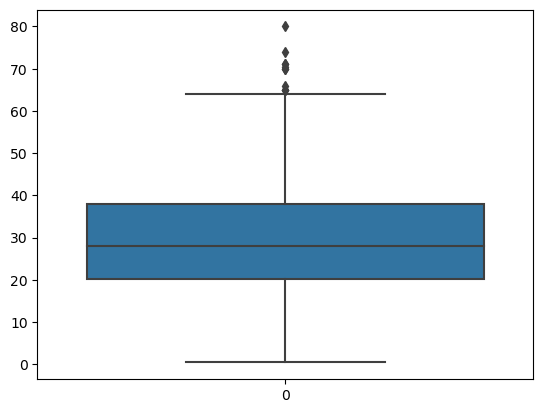

In [800]:
sns.boxplot(train_data_raw['Age'])

We can see that there are a few outliers in the raw input, this is something we can try to remedy along with missing information.
The technique we will try using is mean, mode, and median imputation
 Here's an interesting quote from a Kaggle submission: https://www.kaggle.com/code/pagenotfound/mean-and-median-imputation
 
>Imputation should be done over the training set, and then propagated to the test set. This means that the mean/median to be used to fill missing values both in train and test set, should be extracted from the train set only. And this is to avoid overfitting.

This means that we will need to modify our training data set and also fill missing values in the test set. As to how it avoids overfitting, if we fill in the missing values on the training data, but don't fill it out on the test data, when we measure the performance of the model, it will be fitted to the data that we filled but, it won't handle the missing information in the test data adequately.

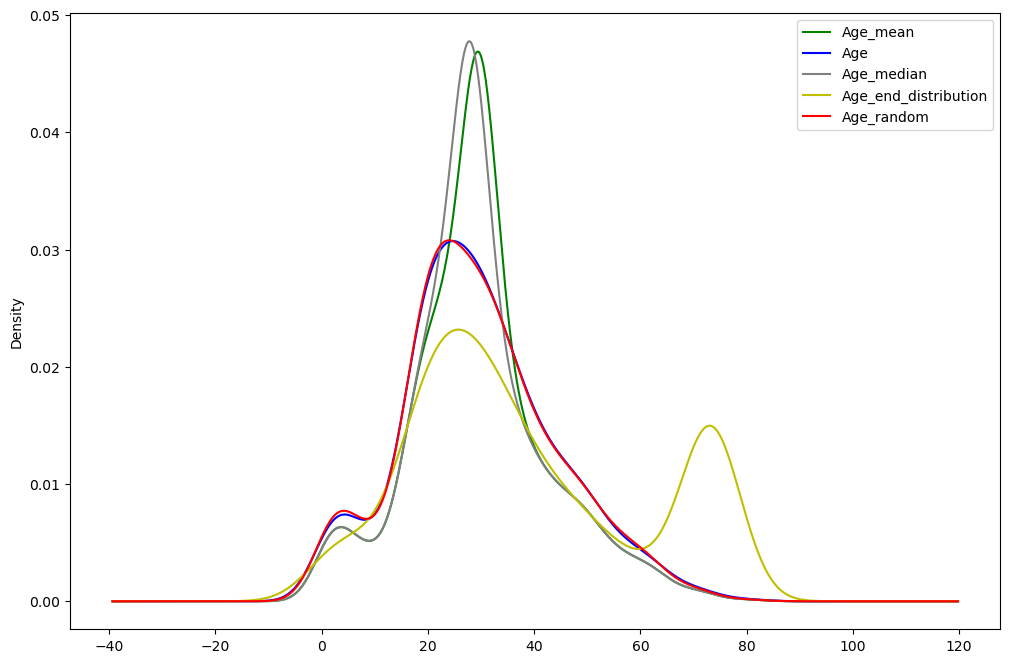

In [801]:
# we fill the missing age data

def mean_median(df,variable):
    df[variable+'_mean']  = df[variable].fillna(df[variable].mean())
    df[variable+'_median']  = df[variable].fillna(df[variable].median())

mean_median(train_data_raw,'Age')

train_data_raw['Age_nan'] = np.where(train_data_raw['Age'].isnull,0,1)
def Age_fill(df,variable):
    df[variable+'_random'] = df[variable]
    random_values = df[variable].dropna().sample(df[variable].isnull().sum(),random_state=3)
    random_values.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable+'_random'] = random_values
    
Age_fill(train_data_raw, 'Age')

extreme = (train_data_raw['Age'].mean()+(3*train_data_raw['Age'].std()))

def End_distribution(df,variable,extreme):
    df[variable+'_end_distribution'] = df[variable].fillna(extreme)

End_distribution(train_data_raw,'Age',extreme)

plt.figure(figsize=(12,8))
train_data_raw.Age_mean.plot(kind='kde',color='g')
train_data_raw.Age.plot(kind='kde',color='b')
train_data_raw.Age_median.plot(kind='kde',color='grey')
train_data_raw.Age_end_distribution.plot(kind='kde',color='y')
train_data_raw.Age_random.plot(kind='kde',color='r')
plt.legend()

In [802]:
train_data.drop(['Age'], axis = 1)
train_data = pd.concat([train_data, train_data_raw['Age_mean'], train_data_raw['Age_median'], train_data_raw['Age_random'], train_data_raw['Age_end_distribution']], axis = 1)
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_mean,Age_median,Age_random,Age_end_distribution
0,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.28,C85,C,22.0,22.0,22.0,22.00
1,4.0,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.10,C123,S,38.0,38.0,38.0,38.00
2,7.0,0.0,1.0,"McCarthy, Mr. Timothy J",male,54.0,0.0,0.0,17463,51.86,E46,S,26.0,26.0,26.0,26.00
3,11.0,1.0,3.0,"Sandstrom, Miss. Marguerite Rut",female,4.0,1.0,1.0,PP 9549,16.70,G6,S,35.0,35.0,35.0,35.00
4,12.0,1.0,1.0,"Bonnell, Miss. Elizabeth",female,58.0,0.0,0.0,113783,26.55,C103,S,35.0,35.0,35.0,35.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,27.0,27.0,27.00
887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,19.0,19.0,19.00
888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.7,28.0,35.0,73.28
889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,26.0,26.0,26.00


In [803]:
# trying to fill the missing values in embarked
train_data_raw['Embarked']

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

In [804]:
# x = data without output and unique identifiers
x = train_data.drop(['PassengerId', 'Name', 'Ticket', 'Survived'], axis=1)
y = train_data['Survived']
x_names = x.columns

# x_clean = input that are not categorical
x_clean = x.drop(['Cabin', 'Sex', 'Embarked', 'Pclass'], axis=1)
x_clean_names = x_clean.columns

# replace NaN with 'Unknown'
x_num = x
x_num['Cabin'] = x_num['Cabin'].apply(lambda x: x[0] if pd.notna(x) else 'Unknown')

# convert categorical value to numerical value using LabelEncoder
le_cabin = LabelEncoder()
le_sex = LabelEncoder()
le_embarked = LabelEncoder()
x_num['Cabin'] = le_cabin.fit_transform(x_num['Cabin'])
x_num['Sex'] = le_sex.fit_transform(x_num['Sex'].fillna('Unknown'))
x_num['Embarked'] = le_embarked.fit_transform(x_num['Embarked'].fillna('Unknown'))

# x_category = dataframe for categorical features 
x_category = pd.concat([x_num['Cabin'], x_num['Sex'], x_num['Embarked'], x_num['Pclass']], axis=1)
x_category


,Cabin,Sex,Embarked,Pclass
0,2,1,0,1.0
1,2,1,2,1.0
2,4,2,2,1.0
3,6,1,2,3.0
4,2,1,2,1.0
...,...,...,...,...
886,8,0,3,NaN
887,8,0,3,NaN
888,8,0,3,NaN
889,8,0,3,NaN


In [805]:
# Mapping of category value with numerical value

sex_mapping = le_sex.classes_
embarked_mapping = le_embarked.classes_
cabin_mapping = le_cabin.classes_

mappings_df = pd.DataFrame({
    'Sex': pd.Series(sex_mapping),
    'Embarked': pd.Series(embarked_mapping),
    'Cabin': pd.Series(cabin_mapping)
})

mappings_df = mappings_df.fillna("")

print("Mapping of Categorical Value with Numerical Value")
mappings_df


Mapping of Categorical Value with Numerical Value


,Sex,Embarked,Cabin
0,Unknown,C,A
1,female,Q,B
2,male,S,C
3,,Unknown,D
4,,,E
5,,,F
6,,,G
7,,,T
8,,,Unknown


In [806]:
X_arr = x_num.values
Y_arr = y.values

# create train_data with numerical value of categories
train_data_num = pd.concat([y, x_num], axis=1)

# train_data_eda = dataset without categorical data
train_data_eda = train_data.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Pclass'], axis =1)

## EDA with Regular Data

In [807]:
## descriptive stats
set_option('display.width', 100)
set_option('display.precision', 2)
description = train_data_eda.describe()
description

,Survived,Age,SibSp,Parch,Fare,Age_mean,Age_median,Age_random,Age_end_distribution
count,183.00,183.00,183.00,183.00,183.00,891.00,891.00,891.00,891.00
mean,0.67,35.67,0.46,0.48,78.68,29.70,29.36,29.62,38.36
std,0.47,15.64,0.64,0.75,76.35,13.00,13.02,14.54,21.72
min,0.00,0.92,0.00,0.00,0.00,0.42,0.42,0.42,0.42
25%,0.00,24.00,0.00,0.00,29.70,22.00,22.00,20.00,22.00
50%,1.00,36.00,0.00,0.00,57.00,29.70,28.00,28.00,32.00
75%,1.00,47.50,1.00,1.00,90.00,35.00,35.00,38.00,54.00
max,1.00,80.00,3.00,4.00,512.33,80.00,80.00,80.00,80.00


## Notes on Descriptive Statistics
-todo

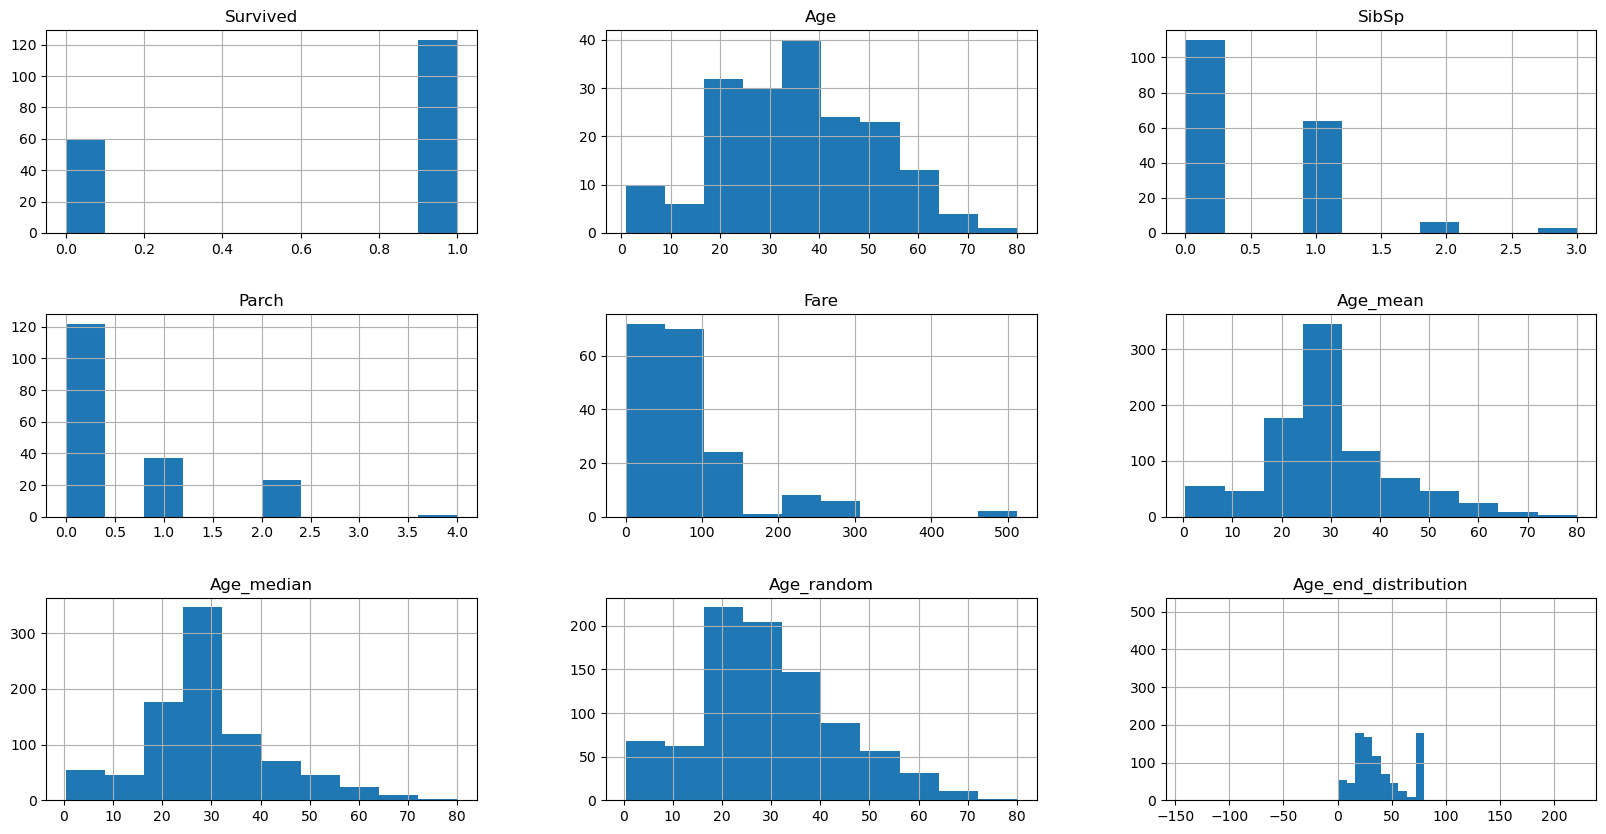

In [808]:
## histograms
train_data_eda.hist(figsize = (20, 10))
plt.margins(2,2)
plt.subplots_adjust(hspace = 0.4)
plt.show()

# Notes on Histograms
-todo

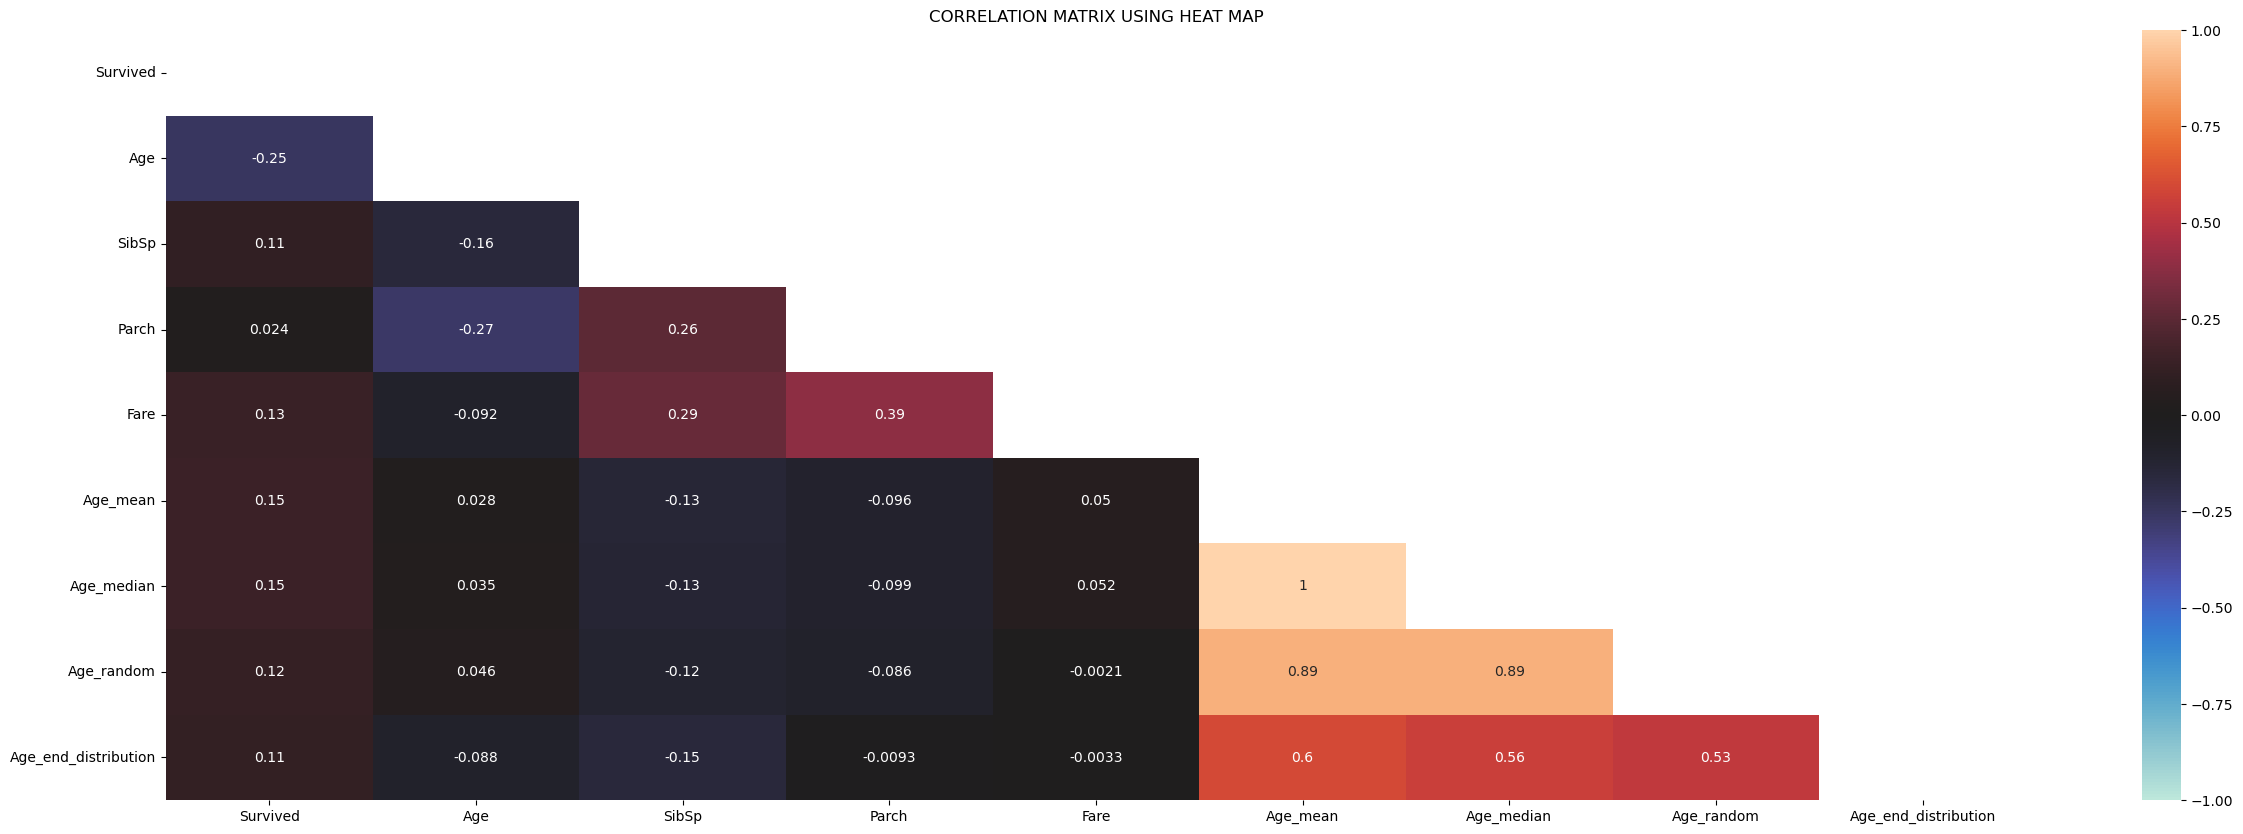

In [809]:
## correlation heatmap   
import seaborn as sns
import numpy as np

plt.figure(figsize=(30,10))
corMat = train_data_eda.corr(method="pearson")
mask_upper = np.triu(corMat)
sns.heatmap(corMat, annot=True, vmin = -1, vmax = 1, center = 0, mask = mask_upper)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title("CORRELATION MATRIX USING HEAT MAP")
plt.show()

## Notes on Heatmap
-todo

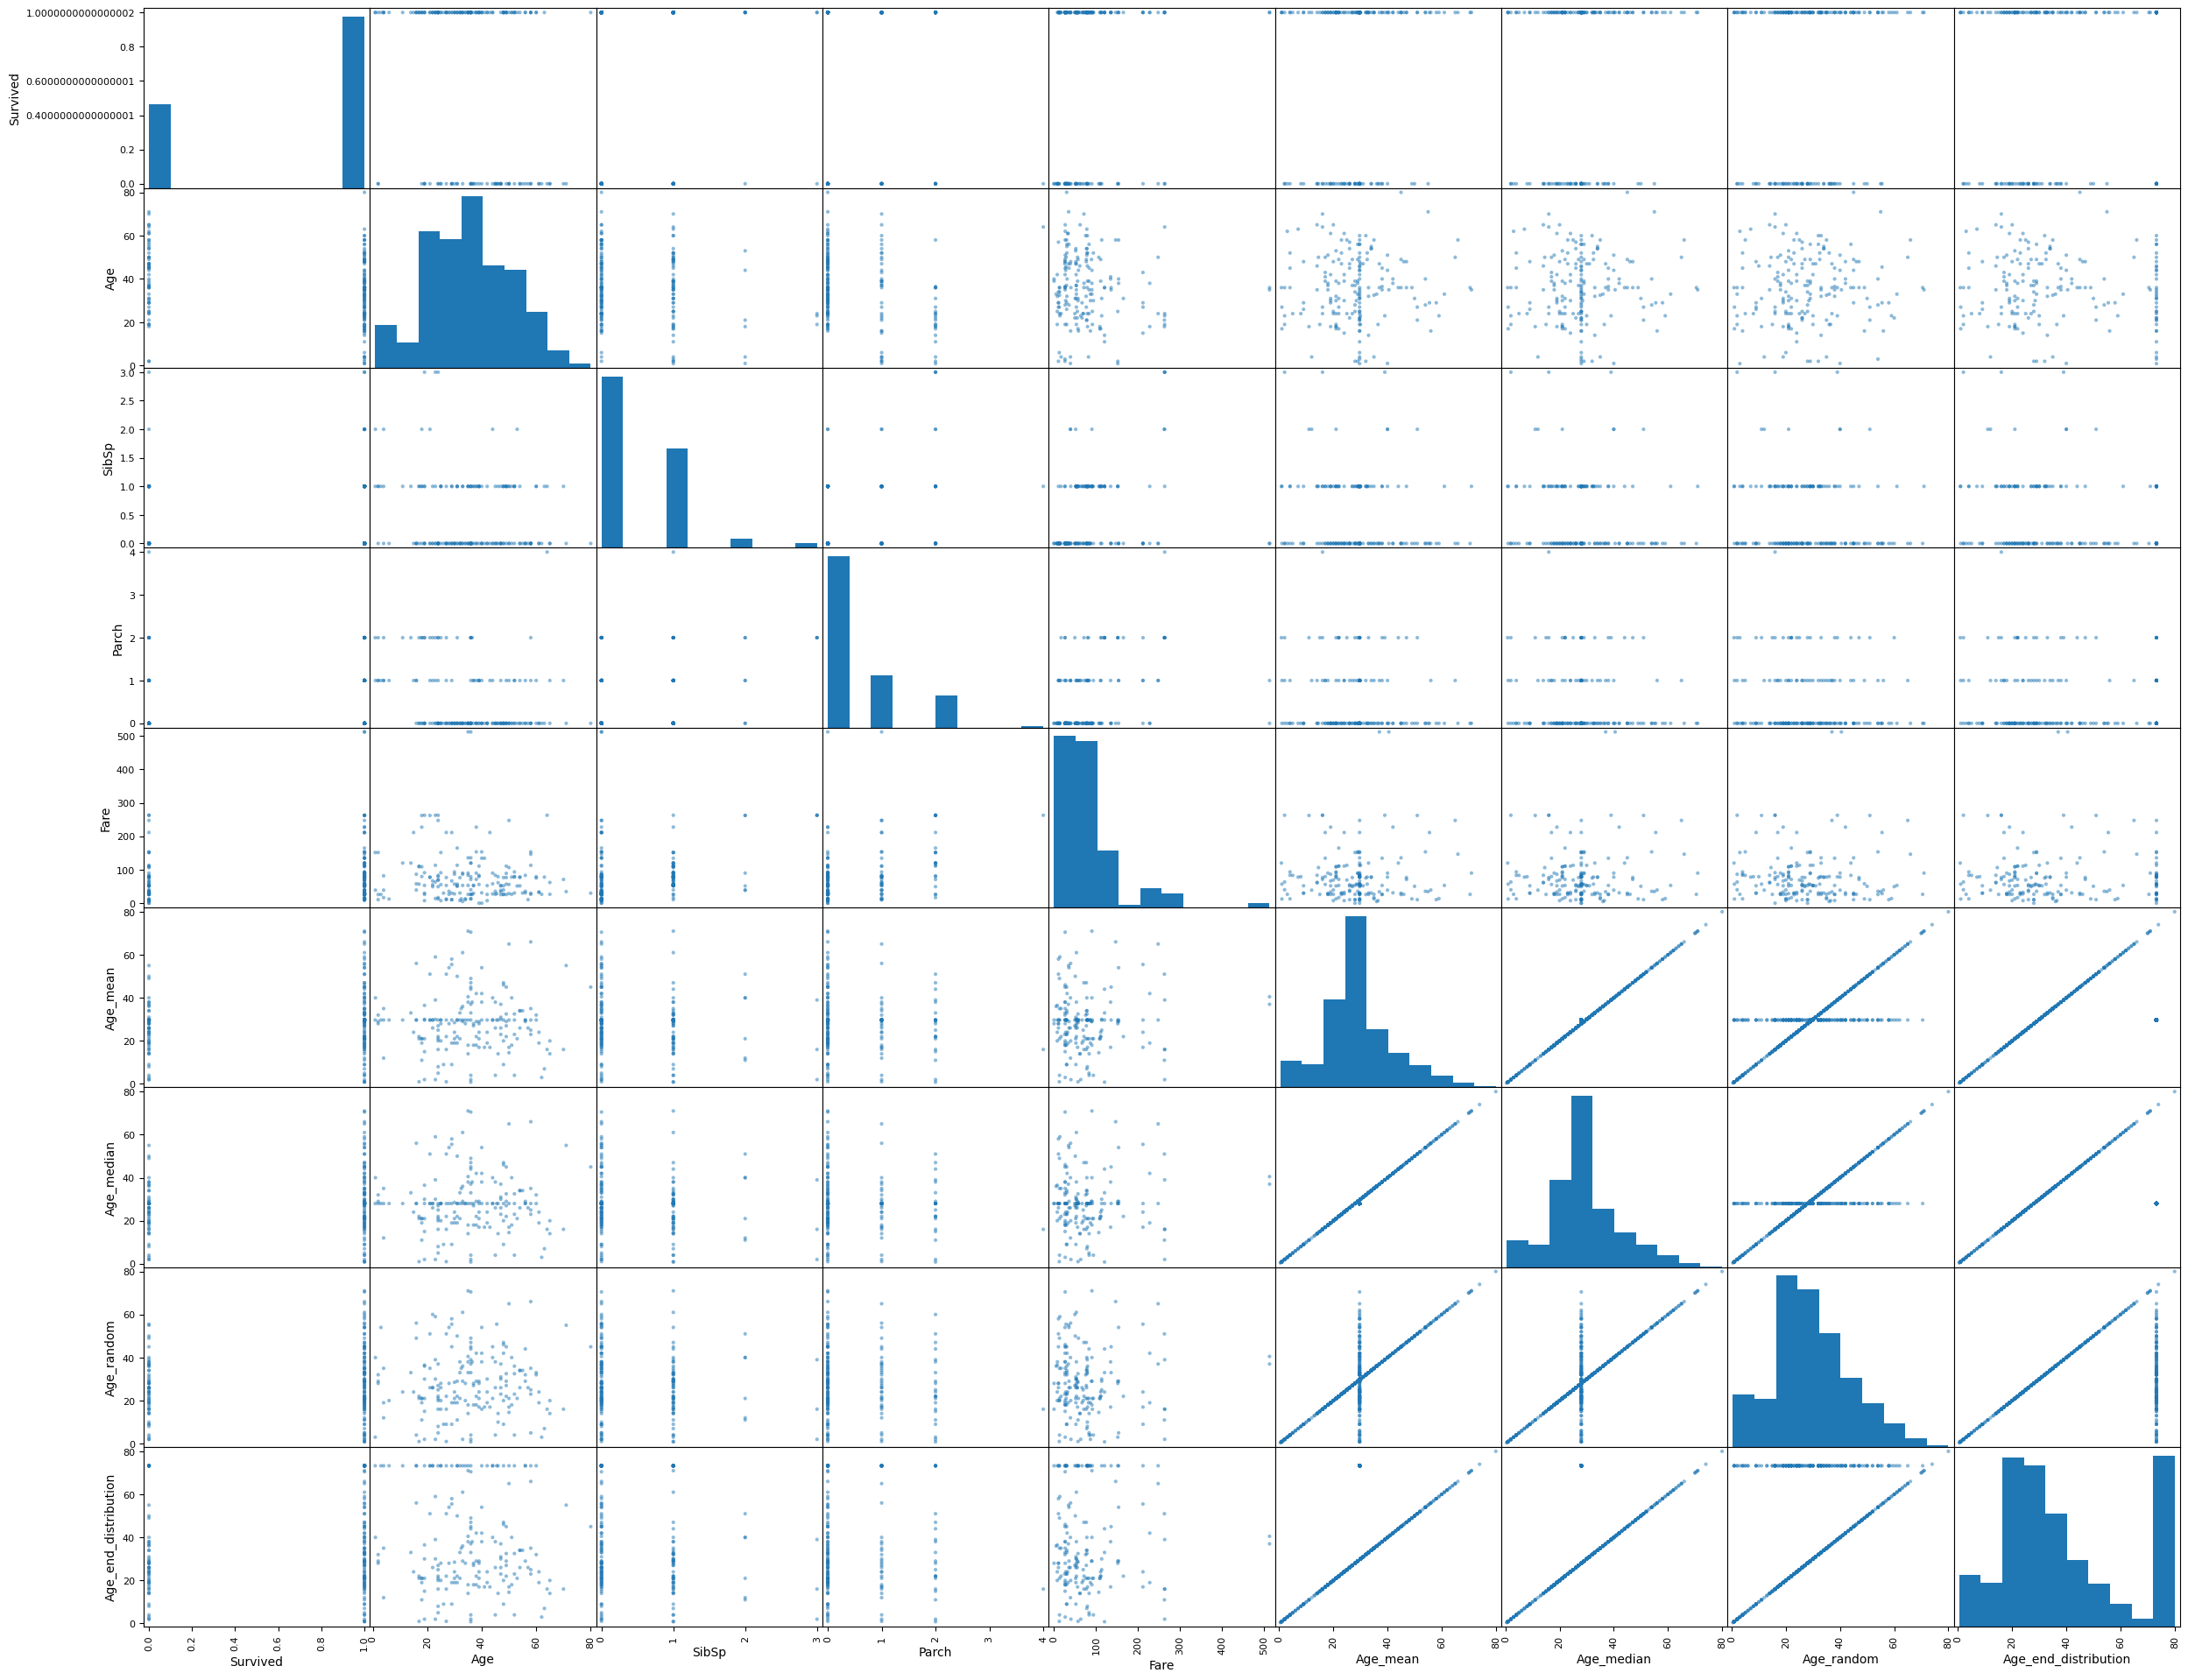

In [810]:
## scatterplots
from pandas.plotting import scatter_matrix

scatter_matrix(train_data_eda, figsize = (30,24))
plt.show()

## Notes on Scatterplots
-todo

## EDA with Standardized Data

In [811]:
data_stan = pd.DataFrame(StandardScaler().fit_transform(x_clean), columns=x_clean_names)
x_stan = pd.concat([data_stan, x_category], axis=1)
x_stan


,Age,SibSp,Parch,Fare,Age_mean,Age_median,Age_random,Age_end_distribution,Cabin,Sex,Embarked,Pclass
0,0.15,0.83,-0.63,-0.10,-0.59,-0.57,-0.52,-0.75,2,1,0,1.0
1,-0.04,0.83,-0.63,-0.34,0.64,0.66,0.58,-0.02,2,1,2,1.0
2,1.17,-0.72,-0.63,-0.35,-0.28,-0.26,-0.25,-0.57,4,2,2,1.0
3,-2.03,0.83,0.70,-0.81,0.41,0.43,0.37,-0.15,6,1,2,3.0
4,1.43,-0.72,-0.63,-0.68,0.41,0.43,0.37,-0.15,2,1,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,NaN,NaN,NaN,NaN,-0.21,-0.18,-0.18,-0.52,8,0,3,NaN
887,NaN,NaN,NaN,NaN,-0.82,-0.80,-0.73,-0.89,8,0,3,NaN
888,NaN,NaN,NaN,NaN,0.00,-0.10,0.37,1.61,8,0,3,NaN
889,NaN,NaN,NaN,NaN,-0.28,-0.26,-0.25,-0.57,8,0,3,NaN


In [812]:
data_stan = pd.concat([y, data_stan], axis=1)
data_stan


,Survived,Age,SibSp,Parch,Fare,Age_mean,Age_median,Age_random,Age_end_distribution
0,1.0,0.15,0.83,-0.63,-0.10,-0.59,-0.57,-0.52,-0.75
1,1.0,-0.04,0.83,-0.63,-0.34,0.64,0.66,0.58,-0.02
2,0.0,1.17,-0.72,-0.63,-0.35,-0.28,-0.26,-0.25,-0.57
3,1.0,-2.03,0.83,0.70,-0.81,0.41,0.43,0.37,-0.15
4,1.0,1.43,-0.72,-0.63,-0.68,0.41,0.43,0.37,-0.15
...,...,...,...,...,...,...,...,...,...
886,NaN,NaN,NaN,NaN,NaN,-0.21,-0.18,-0.18,-0.52
887,NaN,NaN,NaN,NaN,NaN,-0.82,-0.80,-0.73,-0.89
888,NaN,NaN,NaN,NaN,NaN,0.00,-0.10,0.37,1.61
889,NaN,NaN,NaN,NaN,NaN,-0.28,-0.26,-0.25,-0.57


In [813]:
X_arr_stan = x_stan.values
Y_arr_stan = y.values

data_stan.describe()

,Survived,Age,SibSp,Parch,Fare,Age_mean,Age_median,Age_random,Age_end_distribution
count,183.00,1.83e+02,1.83e+02,1.83e+02,1.83e+02,8.91e+02,8.91e+02,8.91e+02,8.91e+02
mean,0.67,-1.65e-16,-3.40e-17,5.82e-17,-1.26e-16,2.23e-16,2.27e-16,9.57e-17,-7.97e-17
std,0.47,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00
min,0.00,-2.23e+00,-7.23e-01,-6.32e-01,-1.03e+00,-2.25e+00,-2.22e+00,-2.01e+00,-1.75e+00
25%,0.00,-7.48e-01,-7.23e-01,-6.32e-01,-6.43e-01,-5.92e-01,-5.66e-01,-6.62e-01,-7.54e-01
50%,1.00,2.09e-02,-7.23e-01,-6.32e-01,-2.85e-01,0.00e+00,-1.05e-01,-1.11e-01,-2.93e-01
75%,1.00,7.58e-01,8.34e-01,6.97e-01,1.49e-01,4.08e-01,4.33e-01,5.77e-01,7.21e-01
max,1.00,2.84e+00,3.95e+00,4.68e+00,5.70e+00,3.87e+00,3.89e+00,3.47e+00,1.92e+00


## Notes on Descriptive Statistics
-todo

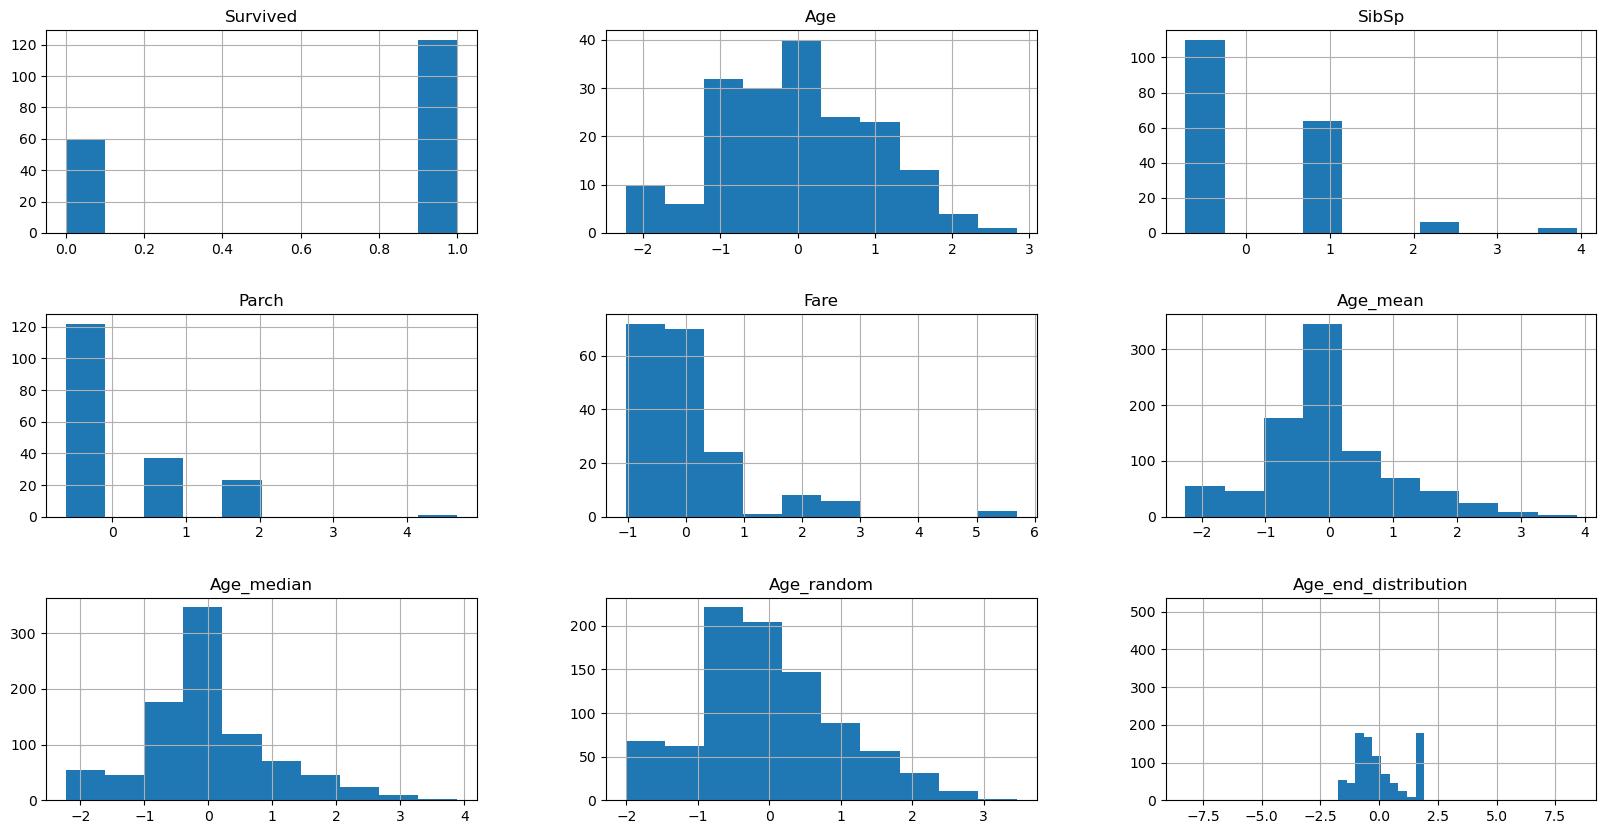

In [814]:
## histograms
data_stan.hist(figsize = (20, 10))
plt.margins(2,2)
plt.subplots_adjust(hspace = 0.4)
plt.show()

# Notes on Histograms
-todo

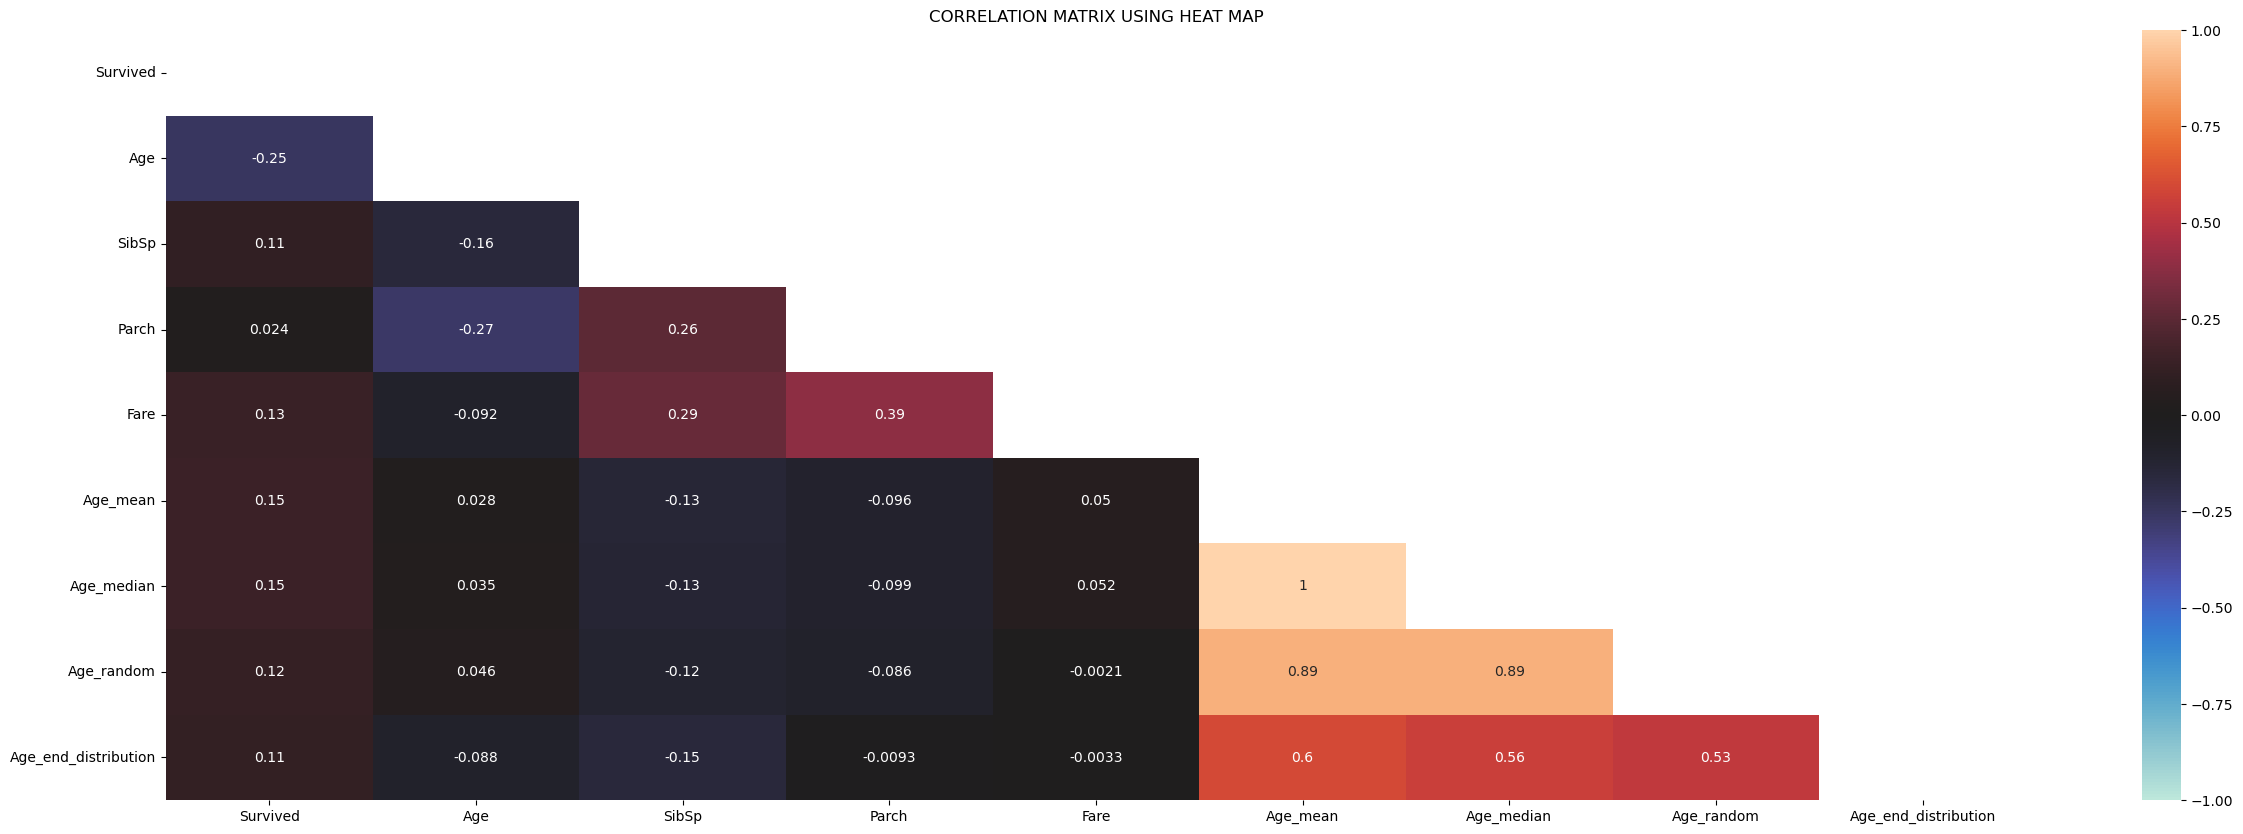

In [815]:
## correlation heatmap   
import seaborn as sns
import numpy as np

plt.figure(figsize=(30,10))
corMat = data_stan.corr(method="pearson")
mask_upper = np.triu(corMat)
sns.heatmap(corMat, annot=True, vmin = -1, vmax = 1, center = 0, mask = mask_upper)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title("CORRELATION MATRIX USING HEAT MAP")
plt.show()

## Notes on Heatmap
-todo

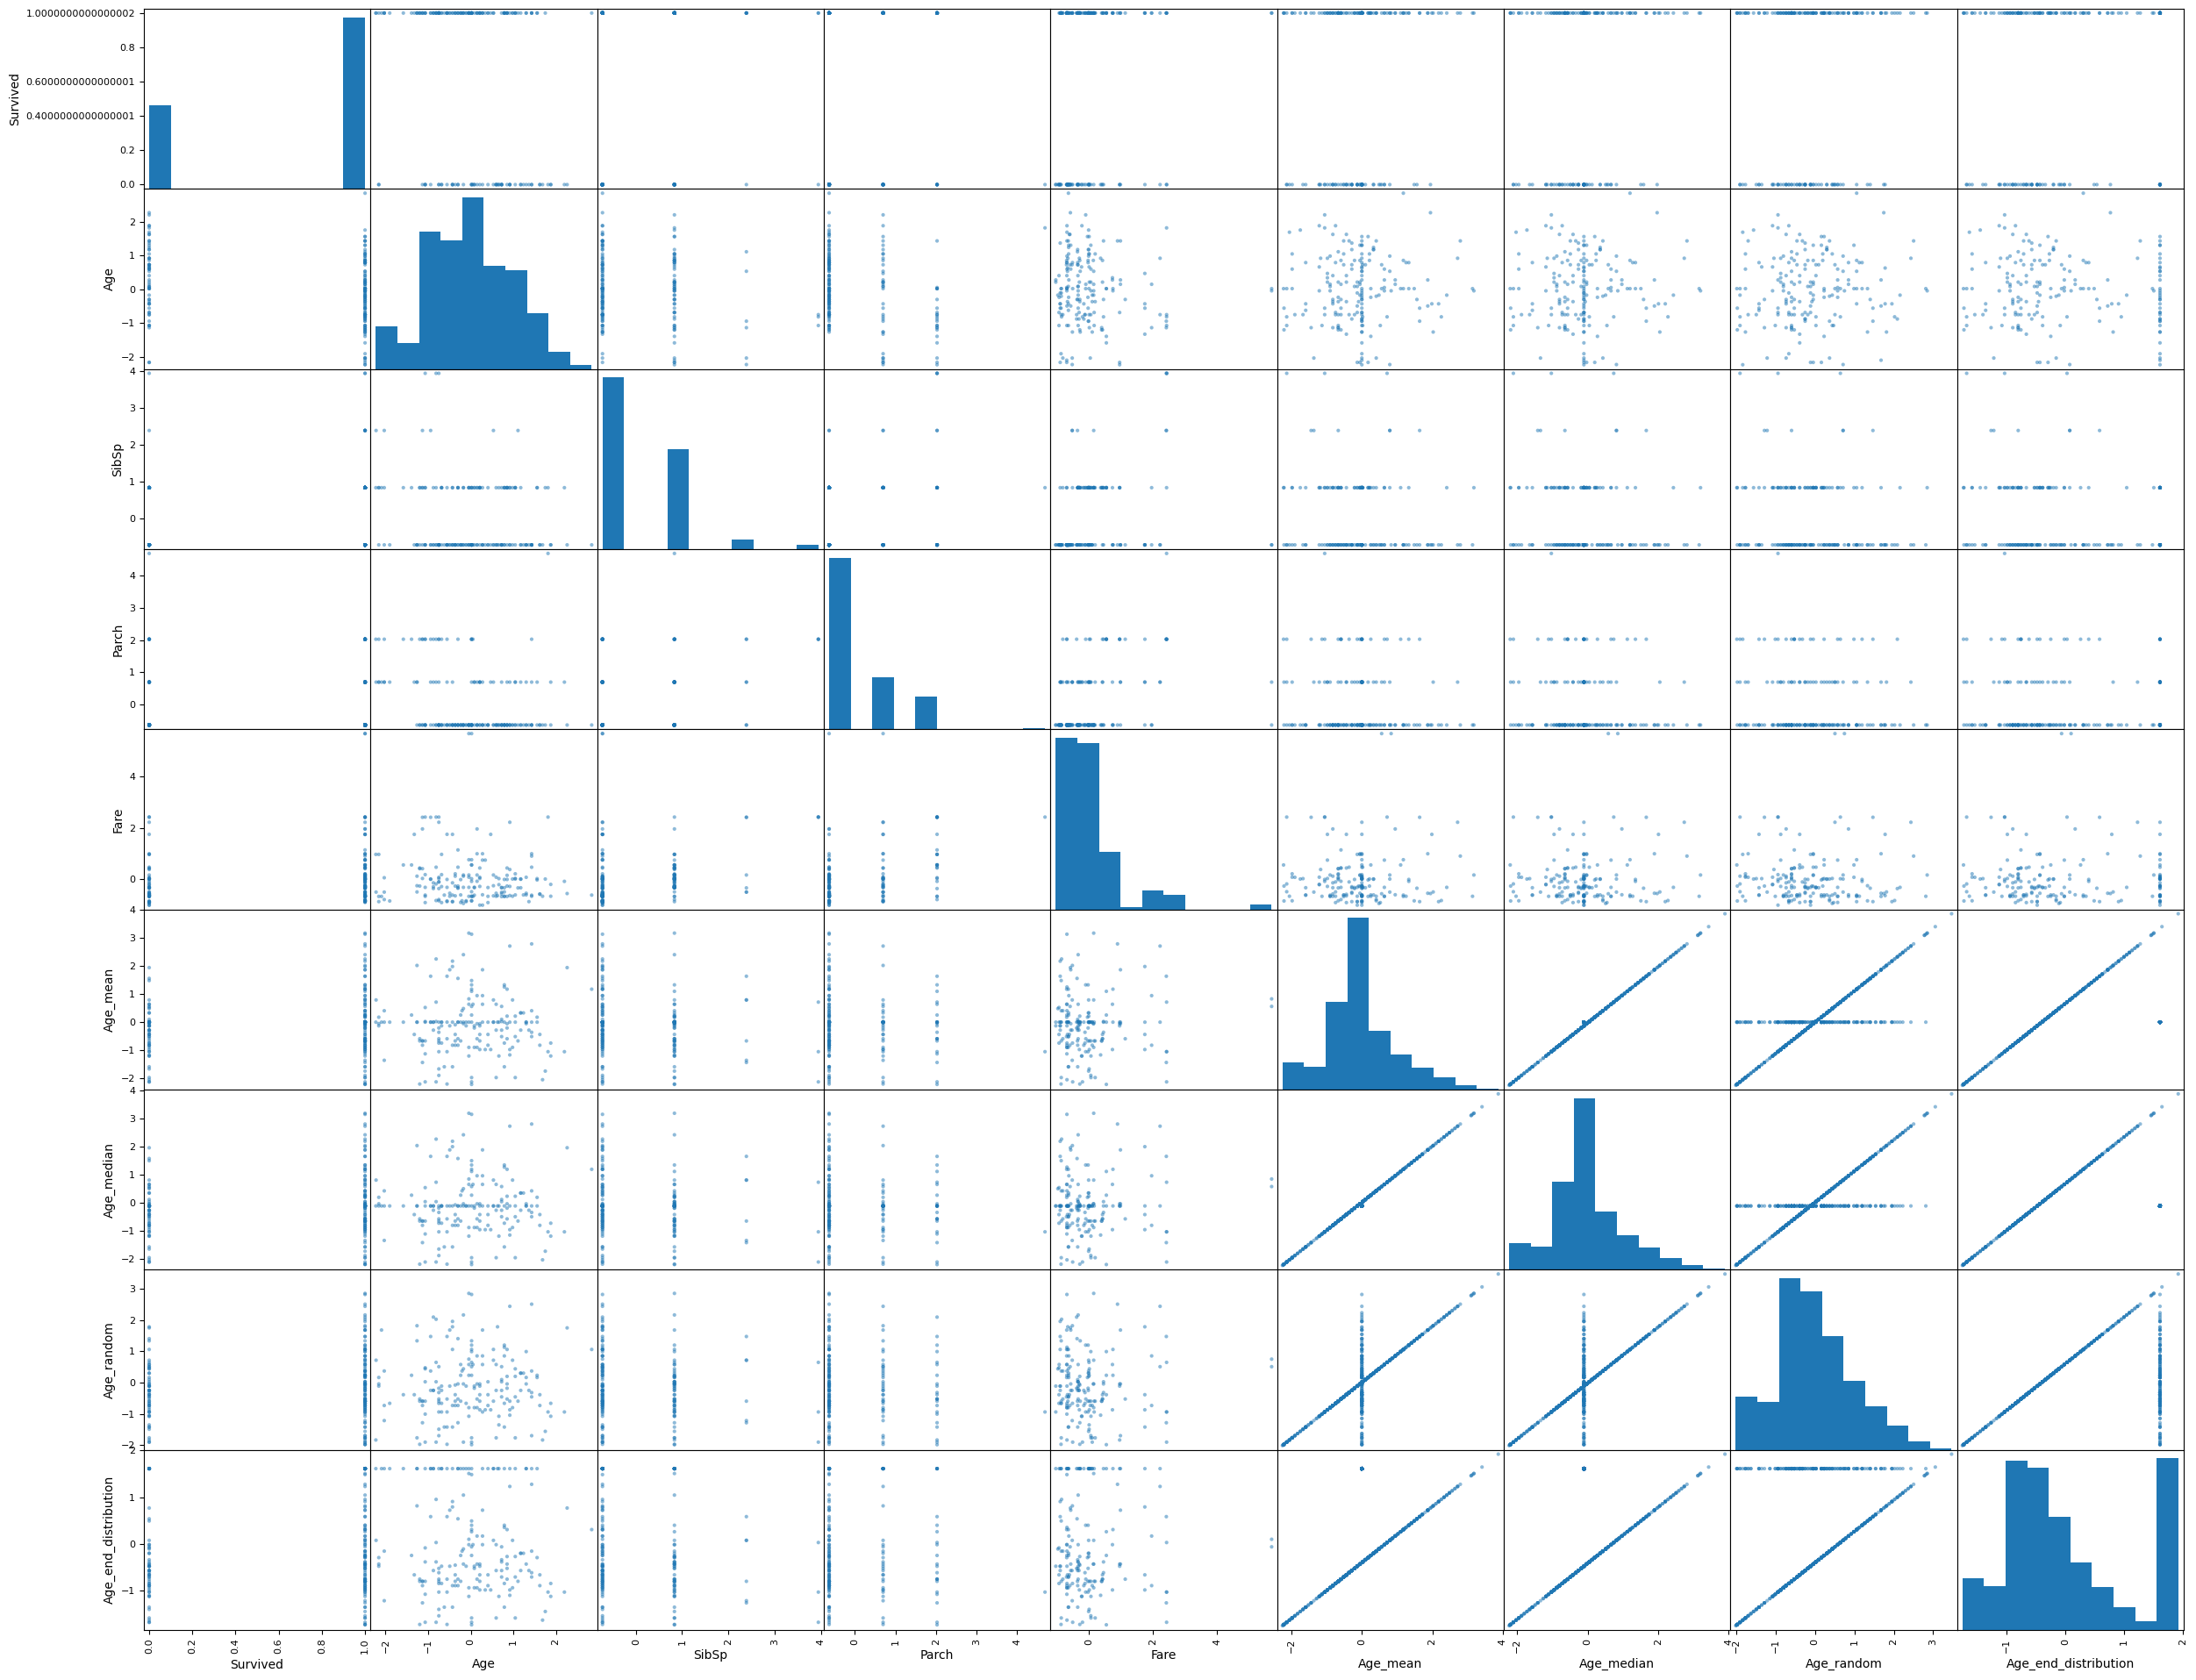

In [816]:
## scatterplots
from pandas.plotting import scatter_matrix

scatter_matrix(data_stan, figsize = (30,24))
plt.show()

## Notes on Scatterplots
-todo

## EDA with Normalized Data

In [817]:
data_norm = pd.DataFrame(MinMaxScaler().fit_transform(x_clean), columns=x_clean_names)
x_norm = pd.concat([data_norm, x_category], axis=1)
x_norm

,Age,SibSp,Parch,Fare,Age_mean,Age_median,Age_random,Age_end_distribution,Cabin,Sex,Embarked,Pclass
0,0.47,0.33,0.00,0.14,0.27,0.27,0.27,0.27,2,1,0,1.0
1,0.43,0.33,0.00,0.10,0.47,0.47,0.47,0.47,2,1,2,1.0
2,0.67,0.00,0.00,0.10,0.32,0.32,0.32,0.32,4,2,2,1.0
3,0.04,0.33,0.25,0.03,0.43,0.43,0.43,0.43,6,1,2,3.0
4,0.72,0.00,0.00,0.05,0.43,0.43,0.43,0.43,2,1,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,NaN,NaN,NaN,NaN,0.33,0.33,0.33,0.33,8,0,3,NaN
887,NaN,NaN,NaN,NaN,0.23,0.23,0.23,0.23,8,0,3,NaN
888,NaN,NaN,NaN,NaN,0.37,0.35,0.43,0.92,8,0,3,NaN
889,NaN,NaN,NaN,NaN,0.32,0.32,0.32,0.32,8,0,3,NaN


In [818]:
X_arr_norm = x_norm.values
Y_arr_norm = y.values

data_norm = pd.concat([y, data_norm], axis=1)
data_norm

,Survived,Age,SibSp,Parch,Fare,Age_mean,Age_median,Age_random,Age_end_distribution
0,1.0,0.47,0.33,0.00,0.14,0.27,0.27,0.27,0.27
1,1.0,0.43,0.33,0.00,0.10,0.47,0.47,0.47,0.47
2,0.0,0.67,0.00,0.00,0.10,0.32,0.32,0.32,0.32
3,1.0,0.04,0.33,0.25,0.03,0.43,0.43,0.43,0.43
4,1.0,0.72,0.00,0.00,0.05,0.43,0.43,0.43,0.43
...,...,...,...,...,...,...,...,...,...
886,NaN,NaN,NaN,NaN,NaN,0.33,0.33,0.33,0.33
887,NaN,NaN,NaN,NaN,NaN,0.23,0.23,0.23,0.23
888,NaN,NaN,NaN,NaN,NaN,0.37,0.35,0.43,0.92
889,NaN,NaN,NaN,NaN,NaN,0.32,0.32,0.32,0.32


In [819]:
## descriptive stats
set_option('display.width', 100)
set_option('display.precision', 2)
description = data_norm.describe()
description

,Survived,Age,SibSp,Parch,Fare,Age_mean,Age_median,Age_random,Age_end_distribution
count,183.00,183.00,183.00,183.00,183.00,891.00,891.00,891.00,891.00
mean,0.67,0.44,0.15,0.12,0.15,0.37,0.36,0.37,0.48
std,0.47,0.20,0.21,0.19,0.15,0.16,0.16,0.18,0.27
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.29,0.00,0.00,0.06,0.27,0.27,0.25,0.27
50%,1.00,0.44,0.00,0.00,0.11,0.37,0.35,0.35,0.40
75%,1.00,0.59,0.33,0.25,0.18,0.43,0.43,0.47,0.67
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Notes on Descriptive Statistics
-todo

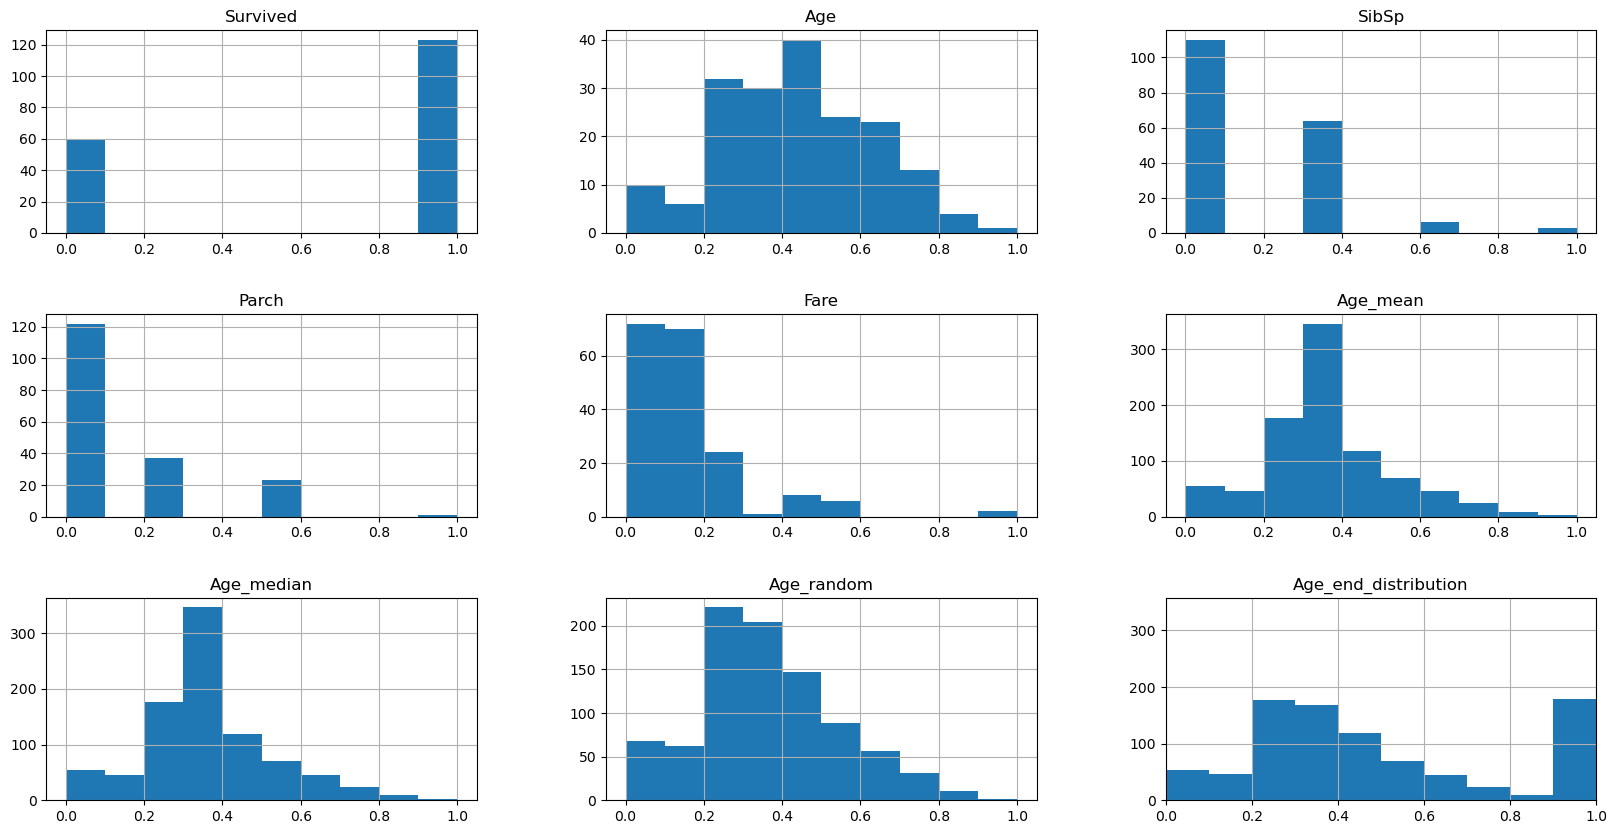

In [820]:
## histograms
data_norm.hist(figsize = (20, 10))
plt.margins(0,1)
plt.subplots_adjust(hspace = 0.4)
plt.show()

# Notes on Histograms
-todo

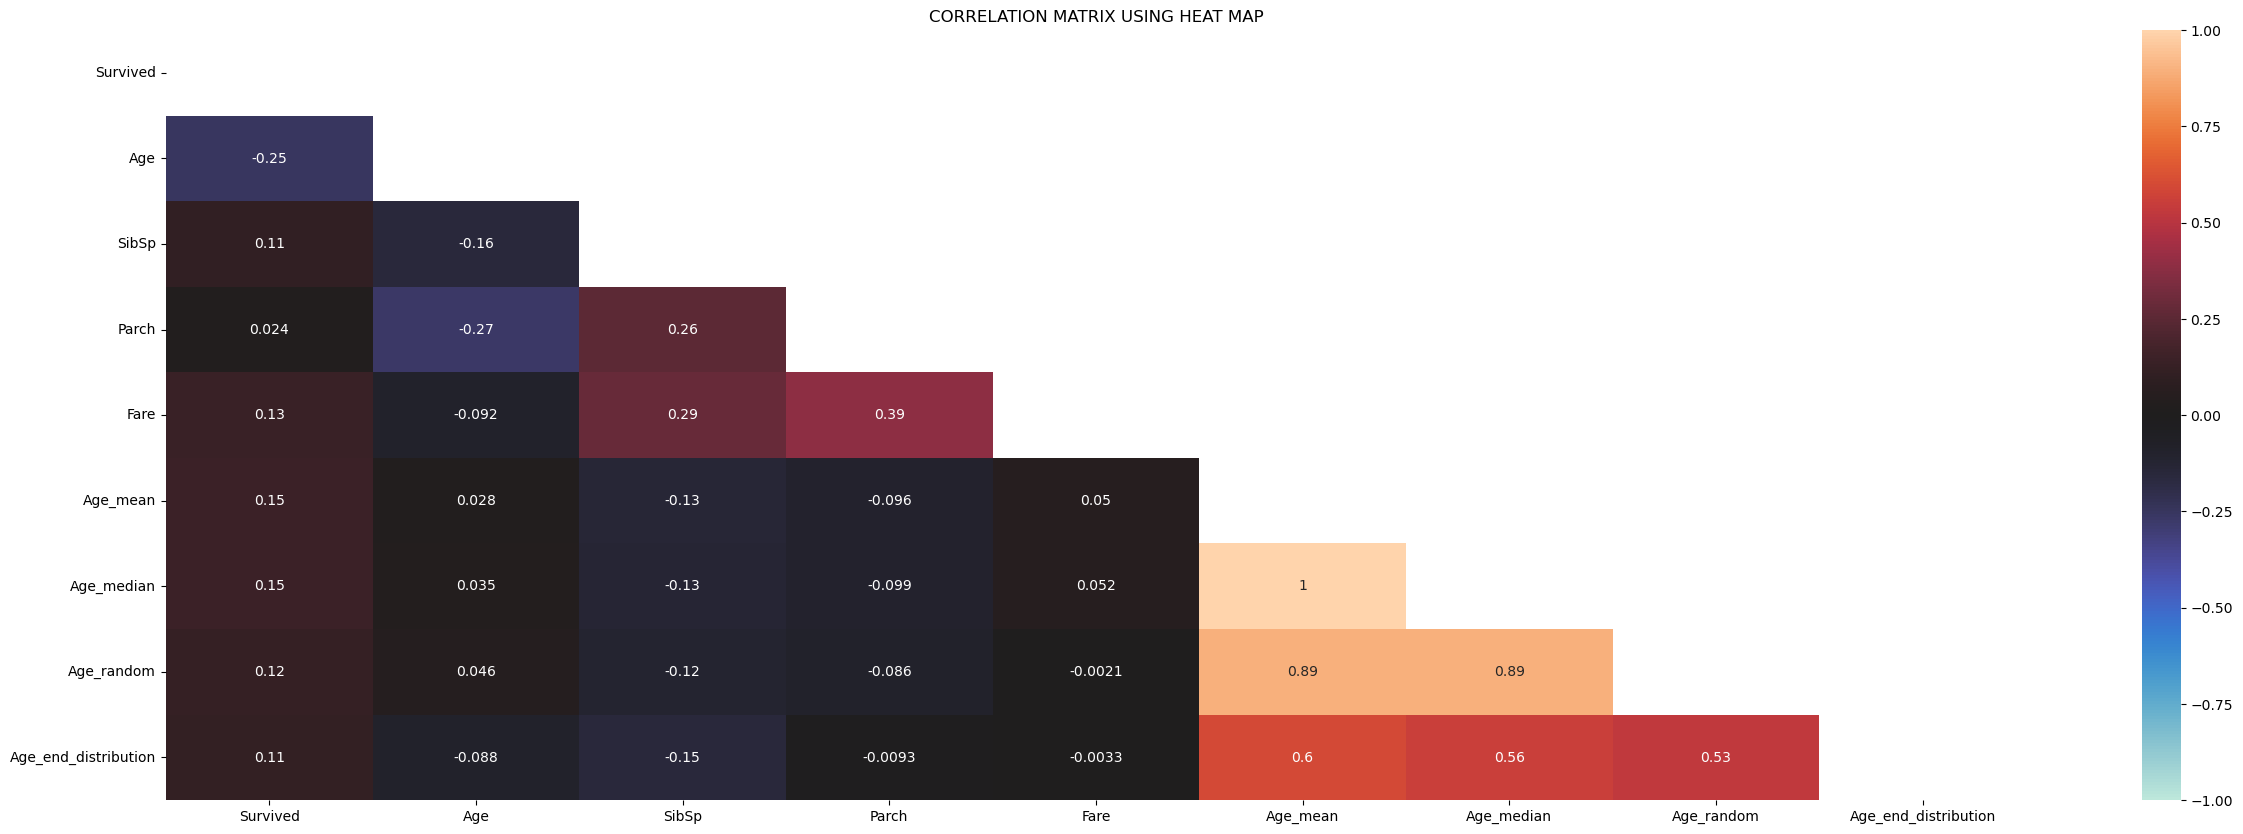

In [821]:
## correlation heatmap   
import seaborn as sns
import numpy as np

plt.figure(figsize=(30,10))
data_norm.corr(method="pearson")
mask_upper = np.triu(corMat)
sns.heatmap(corMat, annot=True, vmin = -1, vmax = 1, center = 0, mask = mask_upper)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title("CORRELATION MATRIX USING HEAT MAP")
plt.show()

## Notes on Heatmap
-todo

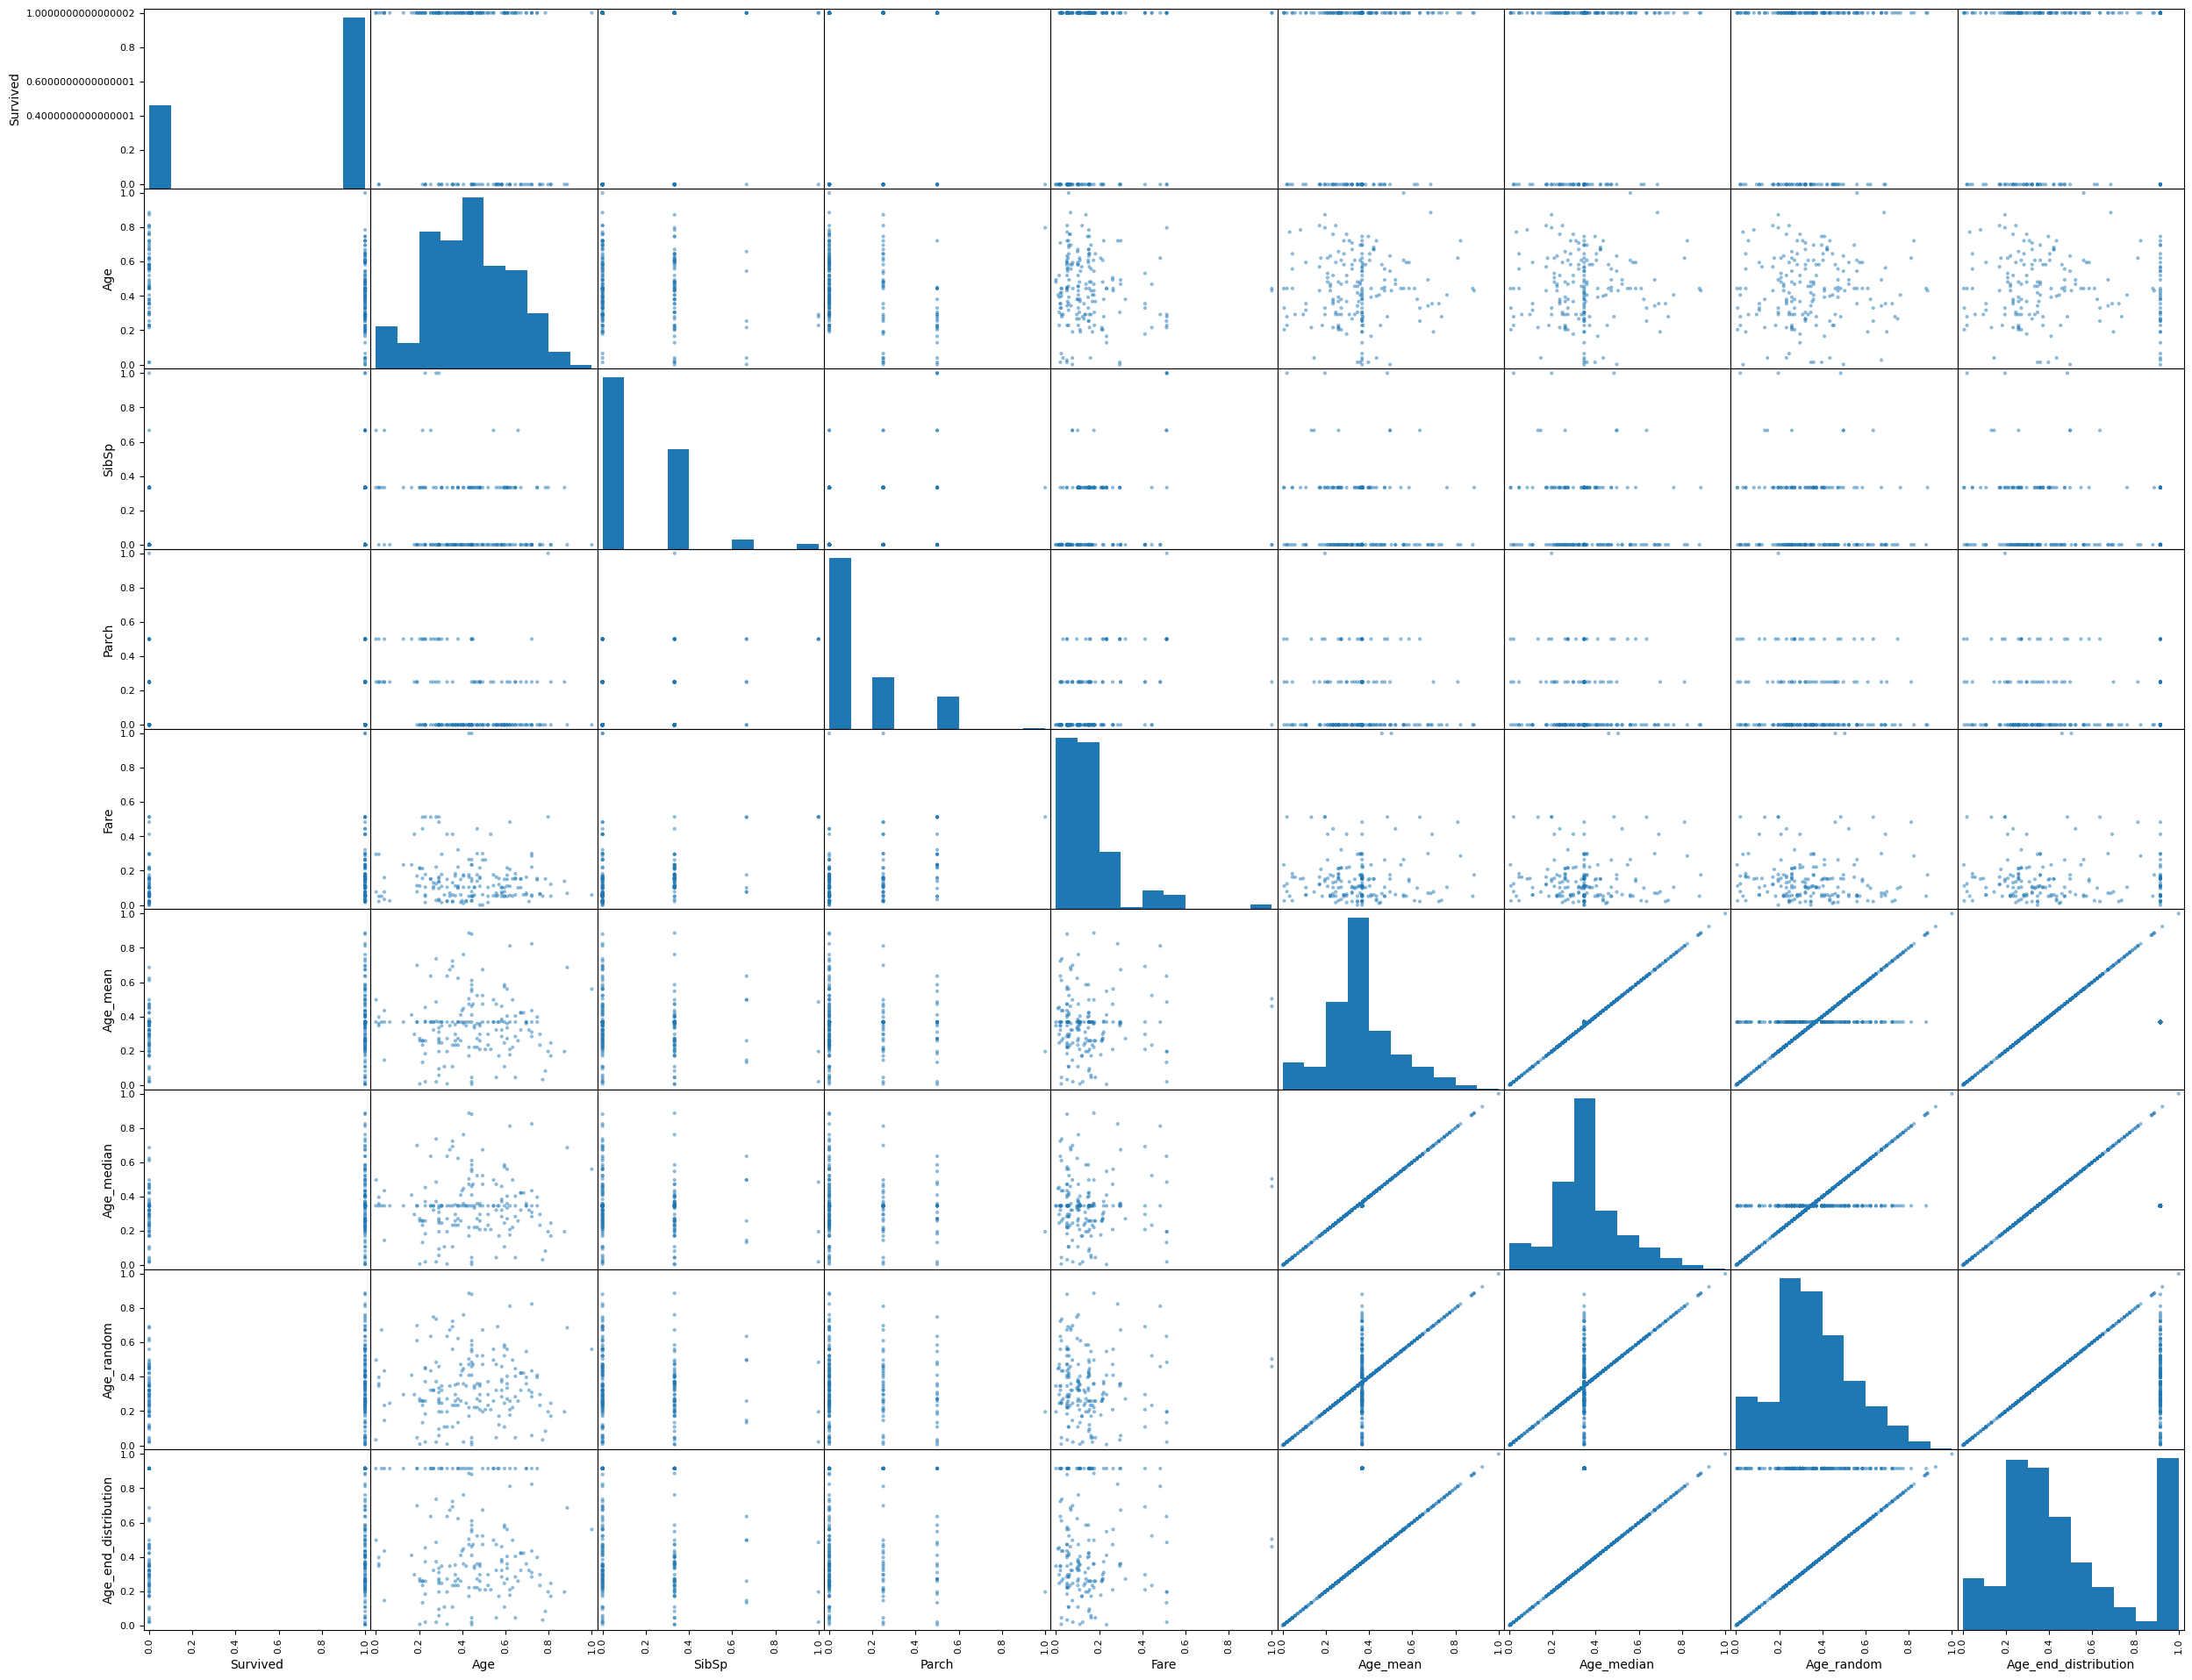

In [822]:
## scatterplots
from pandas.plotting import scatter_matrix

scatter_matrix(data_norm, figsize = (30,24))
plt.show()

## Notes on Scatterplots
-todo

## Model Fitting

In [823]:
# split train data for calculating accuracy

x_train, x_test, y_train, y_test = train_test_split(x_num, y, test_size=0.20, random_state=3)
x_train_stan, x_test_stan, y_train_stan, y_test_stan = train_test_split(x_stan, y, test_size=0.20, random_state=3)
x_train_norm, x_test_norm, y_train_norm, y_test_norm = train_test_split(x_norm, y, test_size=0.20, random_state=3)

### Logistic Regression

In [824]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve


logit_model = LogisticRegression()
logit = logit_model.fit(x_train,y_train)

y_scores =logit.predict_proba(x_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores[:,1])

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="lower left")
    plt.ylim([0, 1])
    plt.ylabel("Precision/Recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

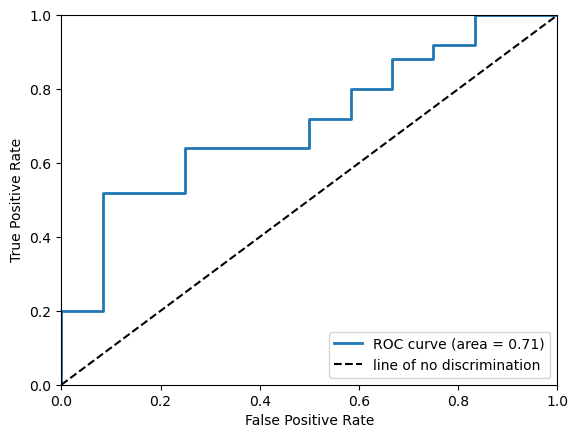

In [ ]:

fpr_lr, tpr_lr, thresholds2 = roc_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr_lr, tpr_lr)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr, linewidth=2, label=label[0])
    plt.plot([0, 1], [0, 1], 'k--', label=label[1])
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plt.figure()
plot_roc_curve(fpr_lr, tpr_lr, ['ROC curve (area = %0.2f)' % roc_auc, 'line of no discrimination'])
plt.legend(loc="lower right")
plt.show()

In [ ]:
logit_model_stan = LogisticRegression()
logit_stan = logit_model.fit(x_train_stan,y_train_stan)

y_scores =logit_stan.predict_proba(x_test_stan)
precisions, recalls, thresholds = precision_recall_curve(y_test_stan, y_scores[:,1])

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="lower left")
    plt.ylim([0, 1])
    plt.ylabel("Precision/Recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:
fpr_lr, tpr_lr, thresholds2 = roc_curve(y_test_stan, y_scores[:,1])
roc_auc = auc(fpr_lr, tpr_lr)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr, linewidth=2, label=label[0])
    plt.plot([0, 1], [0, 1], 'k--', label=label[1])
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plt.figure()
plot_roc_curve(fpr_lr, tpr_lr, ['ROC curve (area = %0.2f)' % roc_auc, 'line of no discrimination'])
plt.legend(loc="lower right")
plt.show()

In [ ]:
logit_model_norm = LogisticRegression()
logit_norm = logit_model_norm.fit(x_train_norm,y_train_norm)

y_scores =logit_norm.predict_proba(x_test_norm)
precisions, recalls, thresholds = precision_recall_curve(y_test_norm, y_scores[:,1])

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="lower left")
    plt.ylim([0, 1])
    plt.ylabel("Precision/Recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:
fpr_lr, tpr_lr, thresholds2 = roc_curve(y_test_norm, y_scores[:,1])
roc_auc = auc(fpr_lr, tpr_lr)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr, linewidth=2, label=label[0])
    plt.plot([0, 1], [0, 1], 'k--', label=label[1])
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plt.figure()
plot_roc_curve(fpr_lr, tpr_lr, ['ROC curve (area = %0.2f)' % roc_auc, 'line of no discrimination'])
plt.legend(loc="lower right")
plt.show()

### Decision Tree Classifier

In [ ]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from io import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image


# decision tree with no max depth
dectree = DecisionTreeClassifier(random_state=3)
dectree.fit(x_train, y_train)

y_pred = dectree.predict(x_test)

df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})

print(accuracy_score(y_test, y_pred))

0.7567567567567568


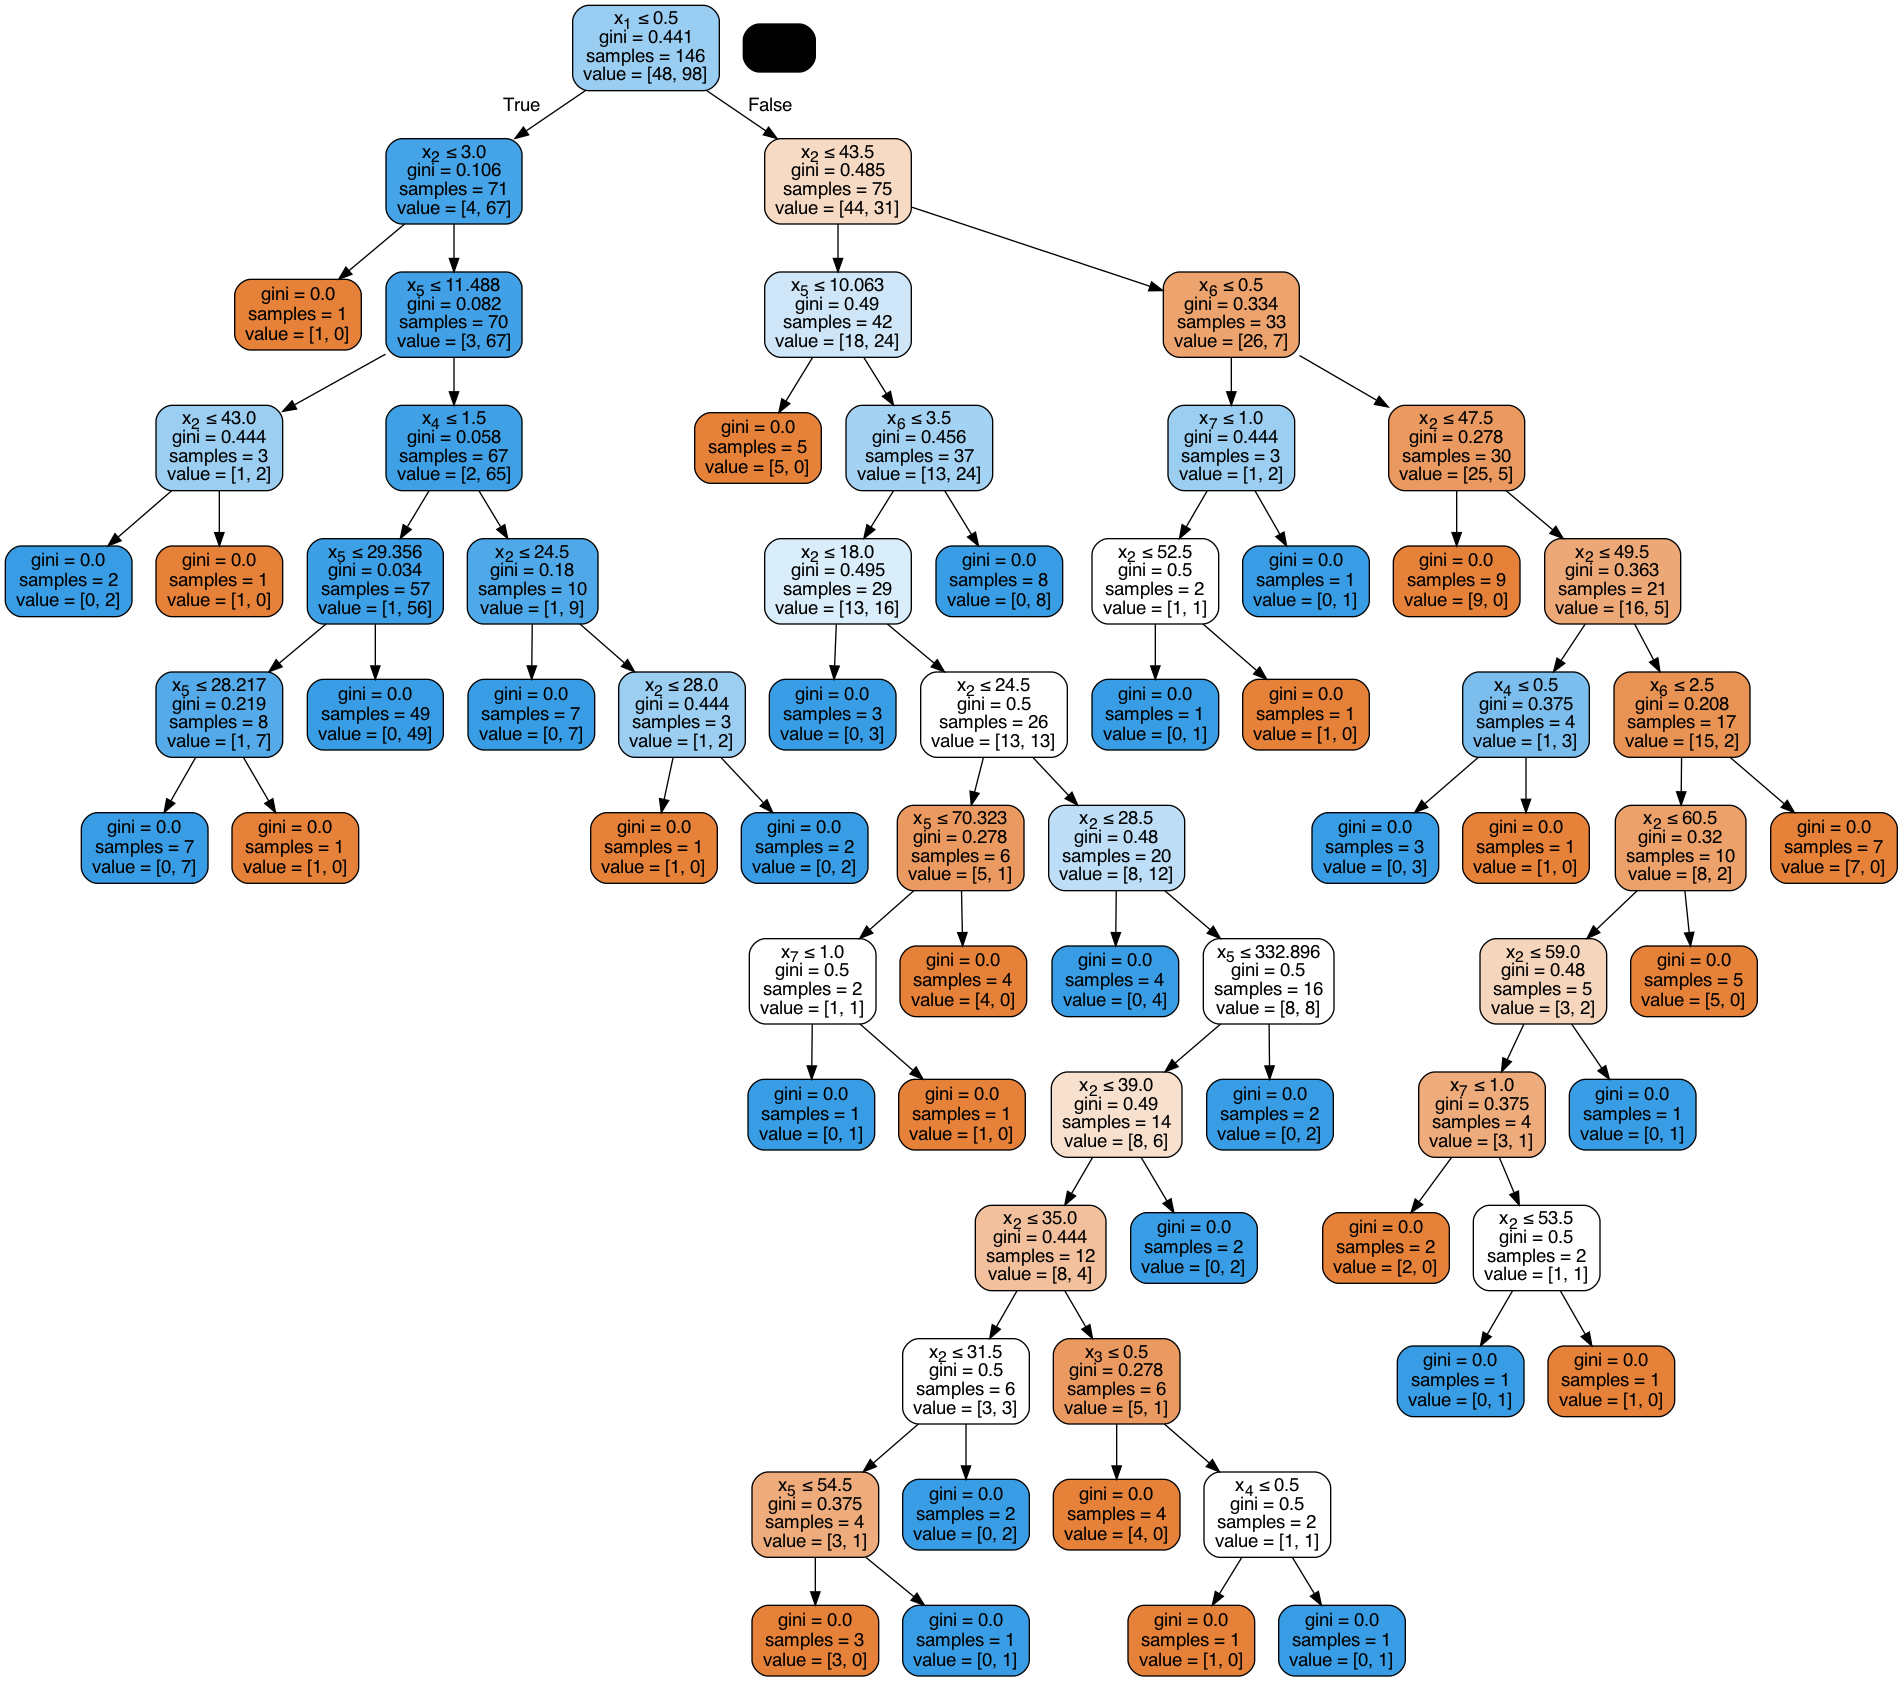

In [ ]:
dot_data = StringIO()
export_graphviz(dectree, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [ ]:
# decision tree with max depth = 6
dectree_6 = DecisionTreeClassifier(max_depth=6, random_state=3)
dectree_6.fit(x_train, y_train)

y_pred = dectree_6.predict(x_test)

df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})

print(accuracy_score(y_test, y_pred))


0.7297297297297297


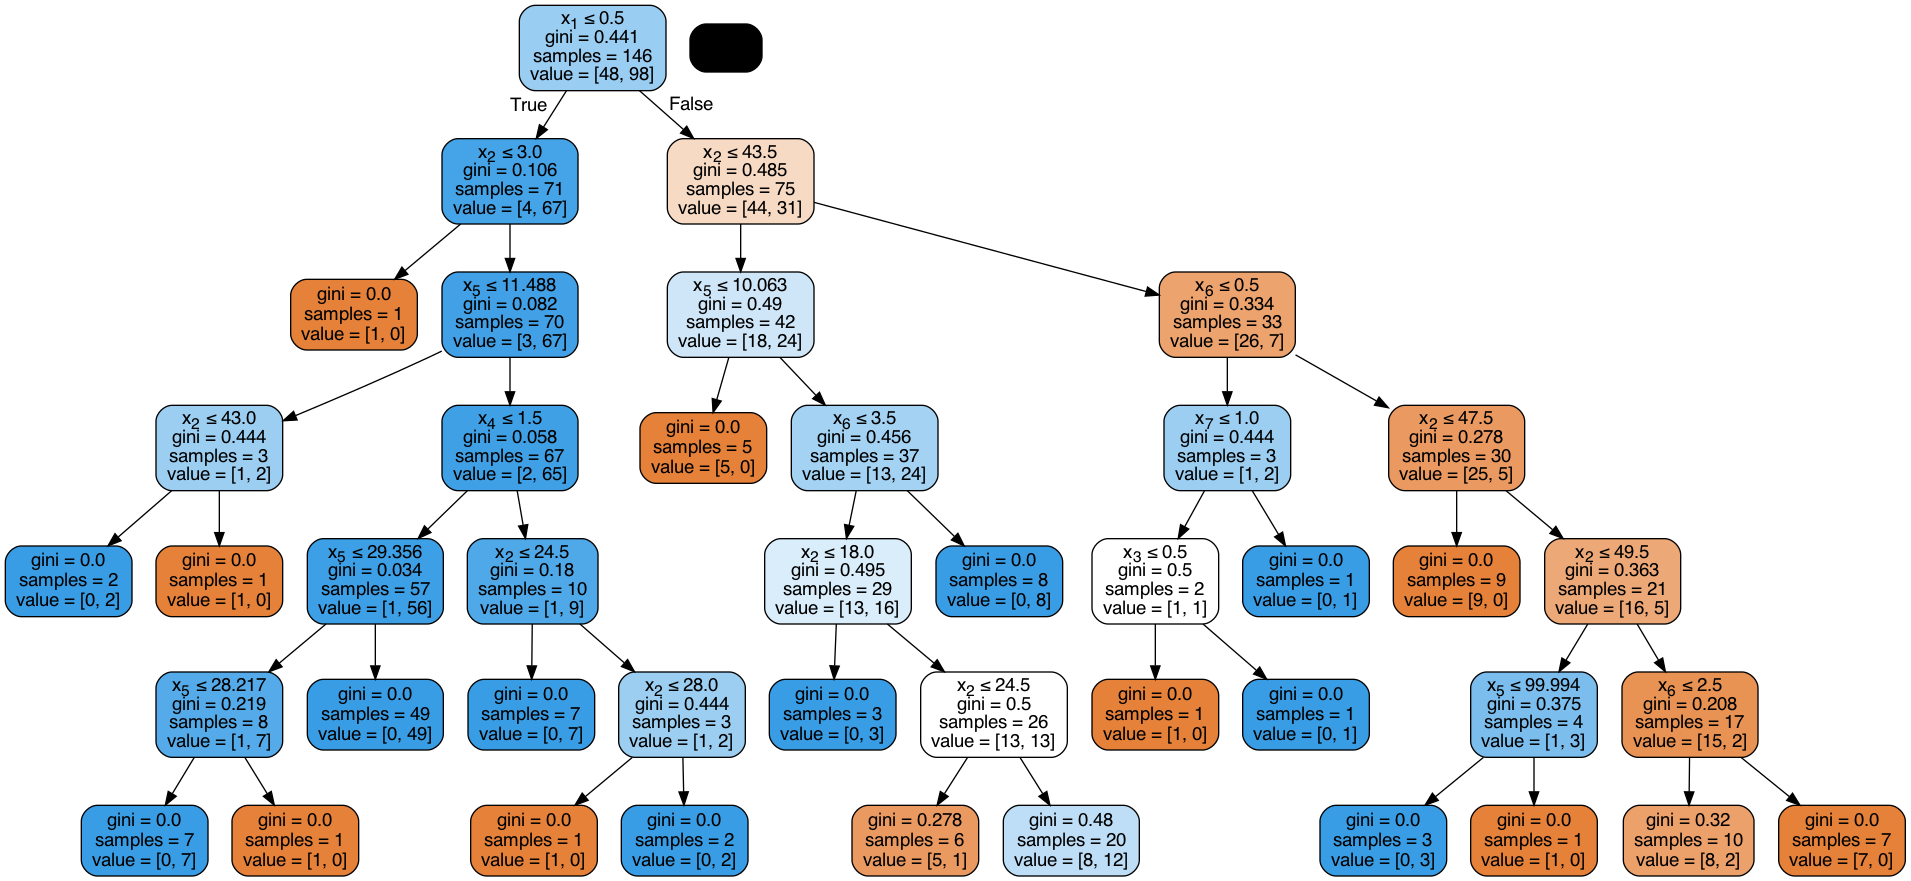

In [ ]:
dot_data = StringIO()
export_graphviz(dectree_6, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [ ]:
dectree_stan = DecisionTreeClassifier(random_state=3)
dectree_stan.fit(x_train_stan, y_train_stan)

y_pred = dectree_stan.predict(x_test_stan)

df=pd.DataFrame({'Actual':y_test_stan, 'Predicted':y_pred})

print(accuracy_score(y_test_stan, y_pred))

In [ ]:
dectree_norm = DecisionTreeClassifier(random_state=3)
dectree_norm.fit(x_train_norm, y_train_norm)

y_pred = dectree_norm.predict(x_test_norm)

df=pd.DataFrame({'Actual':y_test_norm, 'Predicted':y_pred})

print(accuracy_score(y_test_norm, y_pred))

### Bagging (Ensemble)

In [ ]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
    dectree, n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=3)
bag_clf.fit(x_train, y_train)
y_pred = bag_clf.predict(x_test)

# determine accuracy score for the bagging method
print(accuracy_score(y_test, y_pred))

0.6486486486486487


### Random Forest Classifier (Ensemble)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=3)
rnd_clf.fit(x_train, y_train)
y_prob_rf = rnd_clf.predict_proba(x_test)

y_pred_rf = rnd_clf.predict(x_test)

accuracy_score(y_test, y_pred_rf)


0.6216216216216216

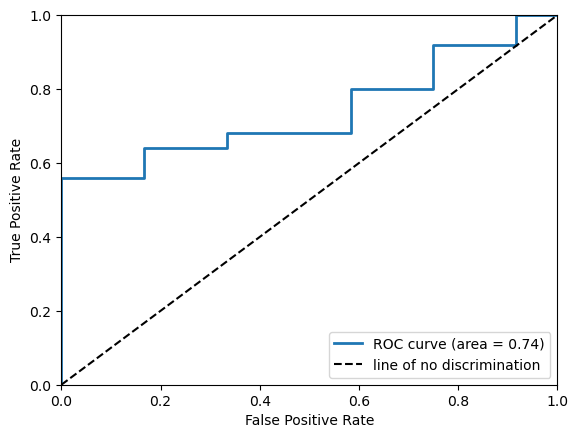

In [ ]:

np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

y_score_rf = y_prob_rf[:,1]
fpr_rf,tpr_rf, threshold_rf = roc_curve(y_test, y_score_rf)
roc_auc = auc(fpr_rf, tpr_rf)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr, linewidth=2, label=label[0])
    plt.plot([0, 1], [0, 1], 'k--', label=label[1])
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr_rf,tpr_rf, ['ROC curve (area = %0.2f)' % roc_auc, 'line of no discrimination'])
plt.legend(loc="lower right")
plt.show()

### ADA Boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=3)
ada_clf.fit(x_train, y_train)

y_pred_ada = ada_clf.predict(x_test)
accuracy_score(y_test, y_pred_ada)

0.6216216216216216

### Support Vector Model

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

kernel_types = ['rbf', 'linear', 'poly', 'sigmoid']

for kernel in kernel_types:
    svc = SVC(kernel = kernel, degree = 2, C=1.0, random_state=4, max_iter = 1000000, probability=True)
    svc.fit(x_train, y_train)
    y_prob_ovo = svc.predict_proba(x_test)

    y_pred_ovo = svc.predict(x_test)



    print(f'accuracy score for {kernel} : ', accuracy_score(y_test, y_pred_ovo))

svc_rbf = SVC(kernel = 'rbf', degree = 2, C=1.0, random_state=4, max_iter = 1000000, probability=True)

### Neural Network

## Cross Validation with K-fold

In [ ]:
# prepare models
from sklearn.model_selection import KFold, cross_val_score


models = []
# OVO is selected instead of OVA as there are only 3 classes
models.append(('Logistic Regression', logit))
models.append(('Decision Tree', dectree))
models.append(('Decision Tree with Max Depth of 6', dectree_6))
models.append(('Bagging', bag_clf))
models.append(('Bagging with Decision Tree', bag_clf))
models.append(('Random Forest', rnd_clf))
models.append(('ADA Boost', ada_clf))
models.append(('Support Vector Model', svc_rbf))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=7, shuffle = True)
    cv_results = cross_val_score(model, X_arr, Y_arr, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

/Users/hmak/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hmak/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Logistic Regression: 0.726901 (0.123648)
Decision Tree: 0.706140 (0.094515)
Decision Tree with Max Depth of 6: 0.732164 (0.097314)
Bagging: 0.727778 (0.109260)
Bagging with Decision Tree: 0.727778 (0.109260)
Random Forest: 0.738889 (0.122081)
ADA Boost: 0.754386 (0.092381)
Support Vector Model: 0.673099 (0.127532)


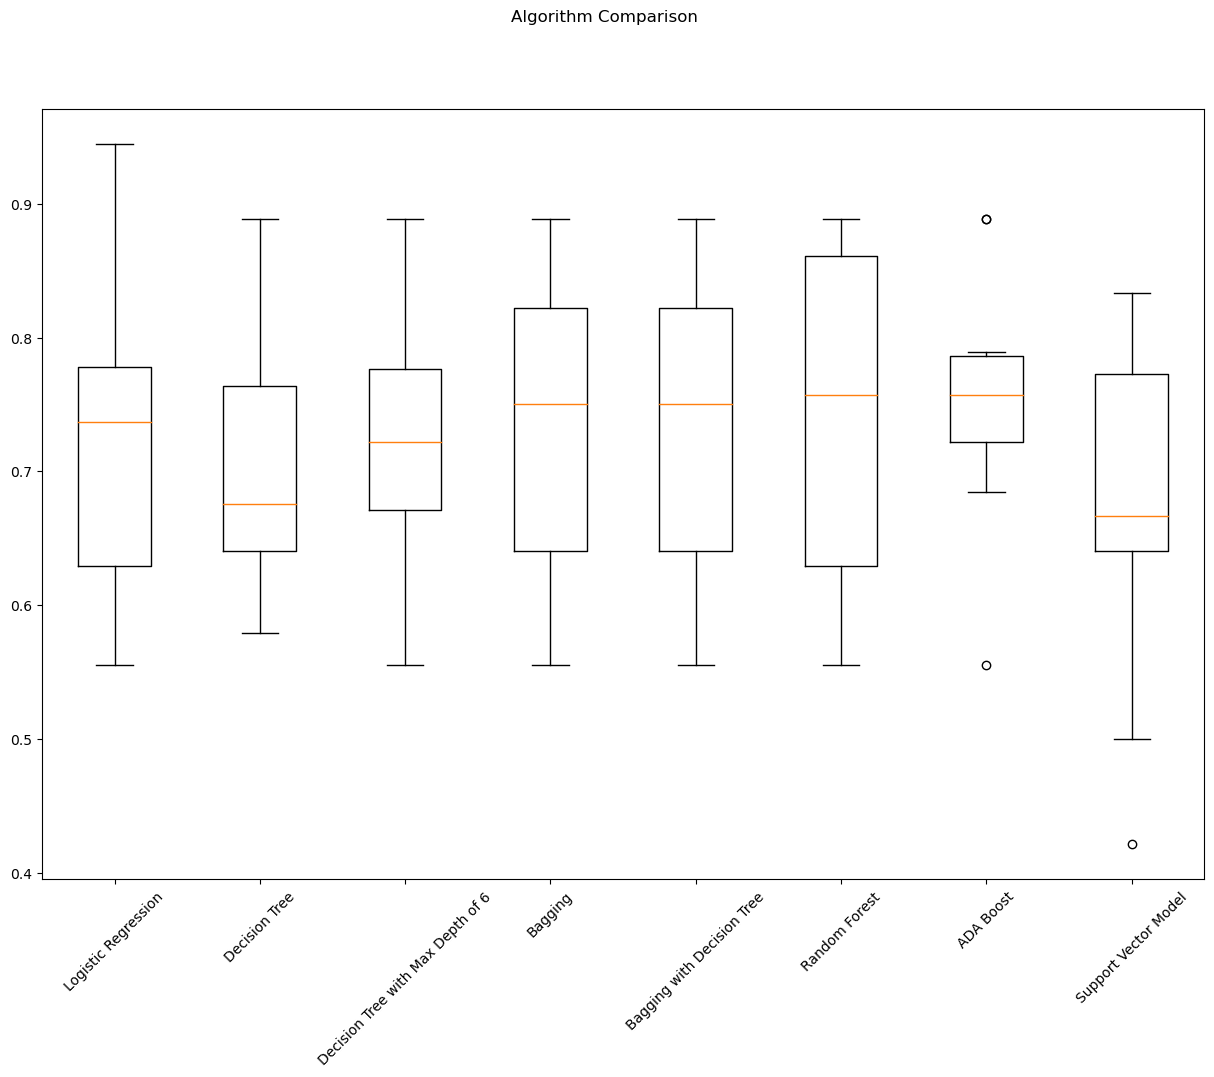

In [ ]:
## boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.xticks(rotation=45)
ax.set_xticklabels(names)
plt.show()

## Conclusions
todo -after everything else

## References


## Appendix

https://github.com/aelichung/ml-titanic